In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools
import torch

from core.koopman_core import KoopDNN,KoopmanNet,KoopmanNetCtrl
from core.koopman_core_linear import KoopDNN_linear, KoopmanNet_linear, KoopmanNetCtrl_linear
from sklearn import preprocessing
from core.util import fit_standardizer
from models.koop_model import model_matricies,lift
from dynamics.duffing import dynamics_duff
from dynamics.Vanpol import dynamics_vanpol
from dynamics.lorentz import dynamics_lorenz

from core.adapt_net import AdaptNet
import scipy.io

In [2]:
# Base Parameters
dt = 0.02 #time step
num_snaps = 100 # no. of snapshots
T = np.linspace(0,num_snaps*dt, num_snaps+1)
num_train = 100 # no. of training examples
num_val = int(0.25*num_train) # no of testing examples
num_traj = num_train+num_val #no of trajectories

In [3]:
# # Oscillator parameters for duffing
system = "Duffing"
linear = True #learn a linear Koopman model
bilinear = False #learn a bilinear Koopman model
BMPC = False

In [4]:
percent_change = 20
Umax = 6
dyn_pars = {}

In [5]:
if system == "Duffing":
    num_states = 2
    num_inputs = 1

    dyn_pars['a'] = -1
    dyn_pars['b'] = 1
    dyn_pars['c'] = 0.5
    dyn_pars['d'] = 0.3

    dyn_pars['del_a'] = dyn_pars['a']*percent_change/100
    dyn_pars['del_b'] = dyn_pars['b']*percent_change/100
    dyn_pars['del_c'] = dyn_pars['c']*percent_change/100
    dyn_pars['del_d'] = dyn_pars['d']*percent_change/100
    dyn_pars['delay'] = False
    dyn_pars['delay_time'] = 5
    dyn_pars['cont_unc_type'] = 'sinusoidal'

    dyn_pars['non_parms'] = False
    dyn_pars["amp"] = 0.5
    dyn_pars["freq"] = 2*np.pi

    dyn_pars['noise'] = False
    dyn_pars["sd"] = 0.06
    dyn_pars['mean'] = 0.0

elif system == "Vander":
    # Oscillator parameters for Van Der pol Oscillator
    num_states = 2
    num_inputs = 1
    mu = 2.5

    dyn_pars['a'] = 1
    dyn_pars['b'] = mu
    dyn_pars['c'] = 0.5
    dyn_pars['d'] = mu

    dyn_pars['del_a'] = dyn_pars['a']*percent_change/100
    dyn_pars['del_b'] = dyn_pars['b']*percent_change/100
    dyn_pars['del_c'] = dyn_pars['c']*percent_change/100
    dyn_pars['del_d'] = dyn_pars['d']*percent_change/100
    dyn_pars['delay'] = False
    dyn_pars['delay_time'] = 5
    dyn_pars['cont_unc_type'] = 'sinusoidal'

    dyn_pars['non_parms'] = False
    dyn_pars["amp"] = 0.5
    dyn_pars["freq"] = 2*np.pi

    dyn_pars['noise'] = False
    dyn_pars["sd"] = 1
    dyn_pars['mean'] = 0.1

In [6]:
if system =="Duffing":
    X_changed, X_unchanged, U = dynamics_duff(dt, num_traj, num_snaps, num_states, num_inputs, dyn_pars)
elif system=="Vander":
    X_changed, X_unchanged, U = dynamics_vanpol(dt, num_traj, num_snaps, num_states, num_inputs, dyn_pars, Umax)

print(X_changed.shape, U.shape)

(125, 101, 2) (125, 100, 1)


In [7]:
# Check for nan values
print(sum(sum(sum(np.isnan(X_changed)))))
print(sum(sum(sum(np.isnan(X_unchanged)))))

0
0


In [8]:
l2_diff = np.linalg.norm(X_changed - X_unchanged) / (X_changed.shape[0]*X_changed.shape[1])
print('l2_diff = ', l2_diff)

l2_diff =  0.0007146411578333663


In [9]:
change_in_dym = np.linalg.norm((X_changed-X_unchanged)/X_changed)/X_changed.size
print('fraction of change in dynamics = ', change_in_dym)

fraction of change in dynamics =  0.05034725969021728


In [10]:
np.linalg.norm(X_changed)

124.16835622199076

In [11]:
file_img = 'saved_models/'+system+"/"+str(percent_change)+'/'

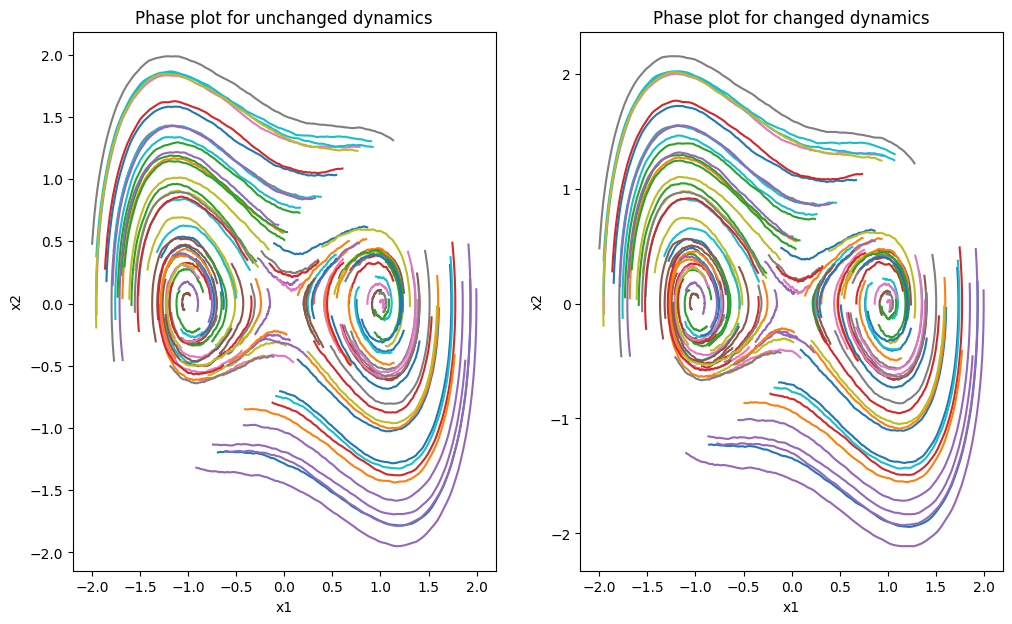

In [12]:
# plot dataset
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title("Phase plot for unchanged dynamics")
axs[1].set_title("Phase plot for changed dynamics")

axs[0].set(xlabel = 'x1', ylabel = 'x2')
axs[1].set(xlabel = 'x1', ylabel = 'x2')

for i in range(num_traj):
    axs[0].plot(X_unchanged[i,:,0], X_unchanged[i,:,1])
    axs[1].plot(X_changed[i,:,0], X_changed[i,:,1])
# plt.savefig(file_img+'phase_plot_duffing.pdf')

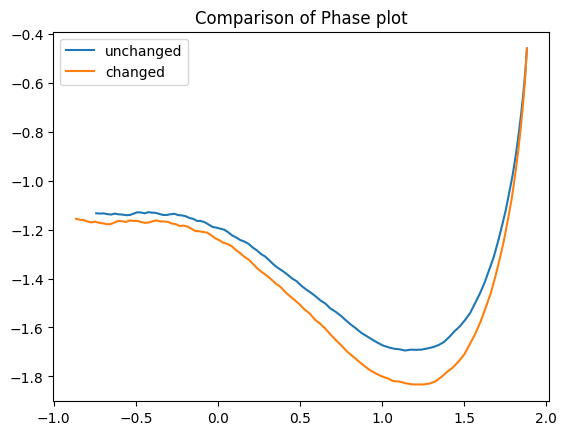

In [13]:
plt.figure()

plt.title('Comparison of Phase plot')
plt.plot(X_unchanged[4,:,0], X_unchanged[4,:,1], label = 'unchanged')
plt.plot(X_changed[4,:,0], X_changed[4,:,1], label = 'changed')

plt.legend()
# plt.savefig(file_img+'phase_plot_duffing_single_traj.pdf')
plt.show()



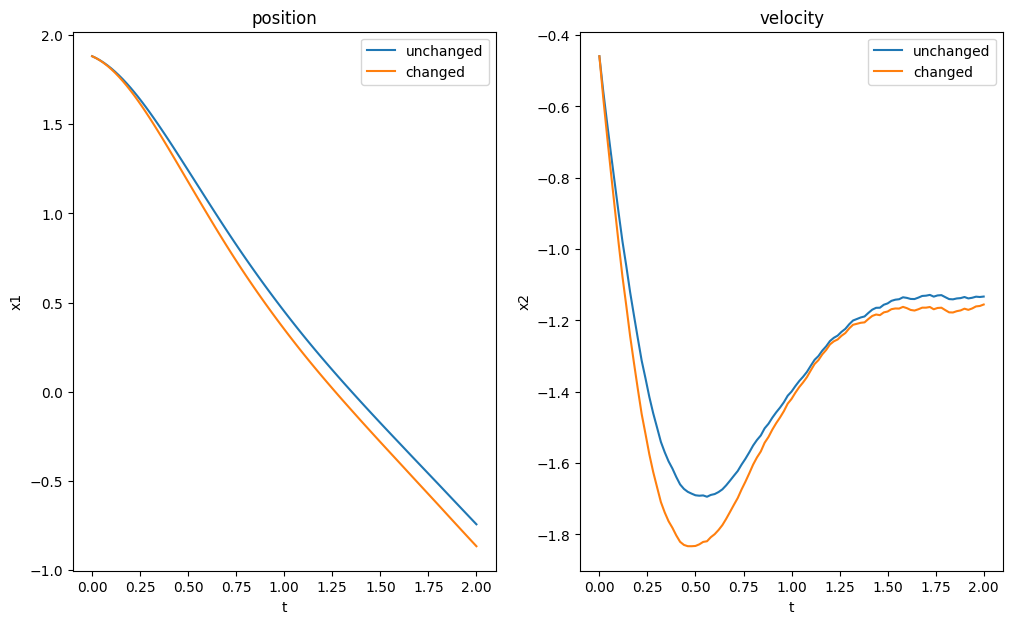

In [14]:
# plot dataset
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title("position")
axs[1].set_title("velocity")

axs[0].set(xlabel = 't', ylabel = 'x1')
axs[1].set(xlabel = 't', ylabel = 'x2')


axs[0].plot(T, X_unchanged[4,:,0], label = 'unchanged')
axs[0].plot(T, X_changed[4,:,0], label = 'changed')
axs[0].legend()

axs[1].plot(T, X_unchanged[4,:,1], label = 'unchanged')
axs[1].plot(T, X_changed[4,:,1], label = 'changed')
axs[1].legend()

# plt.savefig(file_img+'vel_pos_err_duffing_single_traj.pdf')

In [15]:
# split training and vaidation datasets
xs_train, us_train = X_unchanged[:num_train,:,:],U[:num_train,:,:]
xs_val, us_val = X_unchanged[num_train:,:,:],U[num_train:,:,:]

In [16]:
# auto encoder parameters

net_params_bilin = {}
net_params_bilin['state_dim'] = num_states
net_params_bilin['ctrl_dim'] = num_inputs
net_params_bilin['encoder_hidden_width'] = 30
net_params_bilin['encoder_hidden_depth'] = 2
net_params_bilin['encoder_output_dim'] = 10
net_params_bilin['optimizer'] = 'adam'
net_params_bilin['activation_type'] = 'tanh'
net_params_bilin['lr'] = 2e-4 # 5e-4
net_params_bilin['epochs'] = 250
net_params_bilin['batch_size'] = 256
net_params_bilin['lifted_loss_penalty'] = 0.3
net_params_bilin['l2_reg'] = 1e-5
net_params_bilin['l1_reg'] = 1e-5
net_params_bilin['first_obs_const'] = True
net_params_bilin['override_C'] = True # this makes the state a part of lifted state
net_params_bilin['dt'] = dt

In [17]:
train = False
standardize = False
file_koop_bilinear = 'saved_models/'+system+'/bilinear/'+str(net_params_bilin['encoder_output_dim'])+'_dt_'+str(dt)+'.pth'
file_koop_bmpc = 'saved_models/'+system+'/bilinear/'+str(net_params_bilin['encoder_output_dim'])+'_dt_'+str(dt)+'.pth'
standardizer_u_kdnn = fit_standardizer(us_train, preprocessing.StandardScaler(with_mean = True))

In [18]:
if bilinear or BMPC:
    if train == True:

        if standardize:
            net = KoopmanNetCtrl(net_params_bilin, standardizer_u=standardizer_u_kdnn)
        else:
            net = KoopmanNetCtrl(net_params_bilin)
        model_koop_dnn_bilin = KoopDNN(net)
        model_koop_dnn_bilin.set_datasets(xs_train, u_train=us_train, x_val=xs_val, u_val=us_val)
        model_koop_dnn_bilin.model_pipeline(net_params_bilin)
        model_koop_dnn_bilin.construct_koopman_model()
        torch.save(model_koop_dnn_bilin,file_koop_bilinear)
    else:
        model_koop_dnn_bilin = torch.load(file_koop_bilinear)

    train_loss = [l[0] for l in model_koop_dnn_bilin.train_loss_hist]
    train_pred_loss = [l[1] for l in model_koop_dnn_bilin.train_loss_hist]
    train_lifted_loss = [l[2] for l in model_koop_dnn_bilin.train_loss_hist]
    val_loss = [l[0] for l in model_koop_dnn_bilin.val_loss_hist]
    val_pred_loss = [l[1] for l in model_koop_dnn_bilin.val_loss_hist]
    val_lifted_loss = [l[2] for l in model_koop_dnn_bilin.val_loss_hist]
    epochs = np.arange(0, net_params_bilin['epochs'])

    plt.figure(figsize=(15,8))
    plt.plot(epochs, train_loss, color='tab:orange', label='Training loss')
    plt.plot(epochs, train_pred_loss, '--', color='tab:orange', label='Training prediction loss')
    plt.plot(epochs, train_lifted_loss, ':', color='tab:orange', label='Training lifted loss')
    plt.plot(epochs, val_loss, color='tab:blue', label='Validation loss')
    plt.plot(epochs, val_pred_loss, '--', color='tab:blue', label='Validation prediction loss')
    plt.plot(epochs, val_lifted_loss, ':', color='tab:blue', label='Validation lifted loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.show()

In [19]:
# auto encoder parameters

net_params_lin = {}
net_params_lin['state_dim'] = num_states
net_params_lin['ctrl_dim'] = num_inputs
net_params_lin['encoder_hidden_width'] = 30
net_params_lin['encoder_hidden_depth'] = 2
net_params_lin['encoder_output_dim'] = 4
net_params_lin['optimizer'] = 'adam'
net_params_lin['activation_type'] = 'tanh'
net_params_lin['lr'] = 2e-4 # 5e-4
net_params_lin['epochs'] = 200
net_params_lin['batch_size'] = 256
net_params_lin['lifted_loss_penalty'] = 0.3
net_params_lin['l2_reg'] = 1e-5
net_params_lin['l1_reg'] = 1e-5
net_params_lin['first_obs_const'] = True
net_params_lin['override_C'] = True # this makes the state a part of lifted state
net_params_lin['dt'] = dt

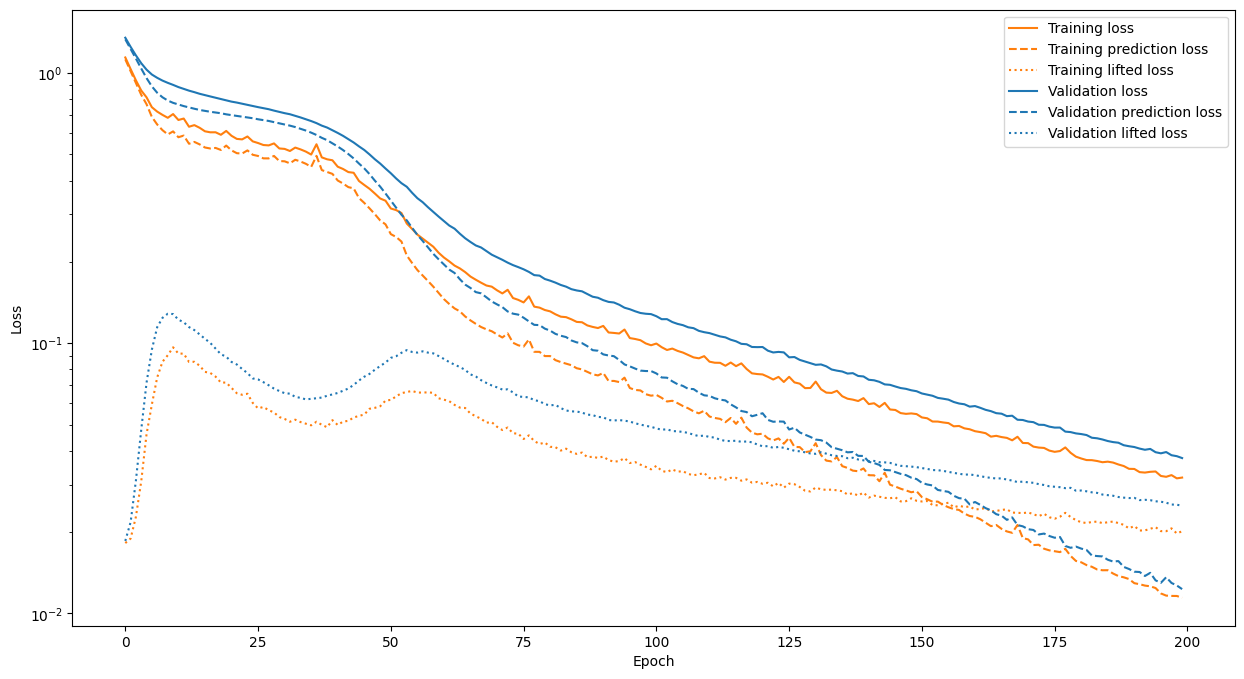

In [20]:

file_koop_linear = 'saved_models/'+system+'/linear/'+str(net_params_lin['encoder_output_dim'])+'_dt_'+str(dt)+'small.pth'

if linear == True:
    if train == True:

        if standardize:
            net_lin = KoopmanNetCtrl_linear(net_params_lin, standardizer_u=standardizer_u_kdnn)
        else:
            net_lin = KoopmanNetCtrl_linear(net_params_lin)
        model_koop_dnn_lin = KoopDNN_linear(net_lin)
        model_koop_dnn_lin.set_datasets(xs_train, u_train=us_train, x_val=xs_val, u_val=us_val)
        model_koop_dnn_lin.model_pipeline(net_params_lin)
        model_koop_dnn_lin.construct_koopman_model()
        torch.save(model_koop_dnn_lin,file_koop_linear)
    else:
        model_koop_dnn_lin = torch.load(file_koop_linear)

    train_loss = [l[0] for l in model_koop_dnn_lin.train_loss_hist]
    train_pred_loss = [l[1] for l in model_koop_dnn_lin.train_loss_hist]
    train_lifted_loss = [l[2] for l in model_koop_dnn_lin.train_loss_hist]
    val_loss = [l[0] for l in model_koop_dnn_lin.val_loss_hist]
    val_pred_loss = [l[1] for l in model_koop_dnn_lin.val_loss_hist]
    val_lifted_loss = [l[2] for l in model_koop_dnn_lin.val_loss_hist]
    epochs = np.arange(0, net_params_lin['epochs'])

    plt.figure(figsize=(15,8))
    plt.plot(epochs, train_loss, color='tab:orange', label='Training loss')
    plt.plot(epochs, train_pred_loss, '--', color='tab:orange', label='Training prediction loss')
    plt.plot(epochs, train_lifted_loss, ':', color='tab:orange', label='Training lifted loss')
    plt.plot(epochs, val_loss, color='tab:blue', label='Validation loss')
    plt.plot(epochs, val_pred_loss, '--', color='tab:blue', label='Validation prediction loss')
    plt.plot(epochs, val_lifted_loss, ':', color='tab:blue', label='Validation lifted loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.show()

In [21]:
# test data parameters
num_snaps_test = 2000 # no. of snapshots
T_test = np.linspace(0,num_snaps_test*dt, num_snaps_test+1)
num_traj_test = 1 # no. of training examples
first_obs_const = int(net_params_bilin['first_obs_const']) #only one state
override_C = net_params_bilin['override_C']
if override_C:
    n_obs_bilin = int(net_params_bilin['encoder_output_dim']) + num_states + first_obs_const
    n_obs_lin = int(net_params_lin['encoder_output_dim']) + num_states + first_obs_const
else:
    n_obs_bilin = int(net_params_bilin['encoder_output_dim']) + first_obs_const
    n_obs_lin = int(net_params_lin['encoder_output_dim']) + first_obs_const

In [22]:
if system =="Duffing":
    x_changed_test, x_unchanged_test,u_test = dynamics_duff(dt, num_traj_test, num_snaps_test,num_states, num_inputs, dyn_pars)
elif system=="Vander":
    x_changed_test, x_unchanged_test, u_test = dynamics_vanpol(dt, num_traj_test, num_snaps_test,num_states, num_inputs, dyn_pars, Umax)

In [23]:
if bilinear or BMPC:
    A_bilin = np.array(model_koop_dnn_bilin.A)
    #B = np.array(model_koop_dnn.B).reshape(-1,num_inputs*n_obs)
    B_bilin = np.array(model_koop_dnn_bilin.B)
    #B_tensor = np.empty((num_inputs,n_obs, n_obs))
    #for ii, b in enumerate(B):
    #B_tensor[ii] = b
    C_bilin = np.array(model_koop_dnn_bilin.C)

    print(A_bilin.shape, B_bilin.shape, C_bilin.shape)

    X_unchanged,_ = model_koop_dnn_bilin.net.process(x_unchanged_test,data_u = u_test)
    X_changed,_ = model_koop_dnn_bilin.net.process(x_changed_test,data_u = u_test)

In [24]:
if linear == True:
    A_lin = np.array(model_koop_dnn_lin.A)
    #B = np.array(model_koop_dnn.B).reshape(-1,num_inputs*n_obs)
    B_lin = np.array(model_koop_dnn_lin.B)
    #B_tensor = np.empty((num_inputs,n_obs, n_obs))
    #for ii, b in enumerate(B):
    #B_tensor[ii] = b
    C_lin = np.array(model_koop_dnn_lin.C)

    print(A_lin.shape, B_lin.shape, C_lin.shape)
    X_unchanged,_ = model_koop_dnn_lin.net.process(x_unchanged_test,data_u = u_test)
    X_changed,_ = model_koop_dnn_lin.net.process(x_changed_test,data_u = u_test)

(7, 7) (7, 1) (2, 7)


In [25]:
# # #SAVE MATRIX PARAMETERS AS MATLAB FILE
# # import scipy.io
# path_model = 'saved_models/'+system+'/linear/matlab_files/'
#
# dyn_matrices = {"A": A_lin, "B": B_lin, "C": C_lin}
# scipy.io.savemat(path_model + "dyn_mat.mat", dyn_matrices)
# #save encoder parameters
#
# encoder_dict = {}
#
# encoder_dict["encoder_in_weights"] =  model_koop_dnn_lin.net.encoder_fc_in.weight.detach().numpy()
# encoder_dict["encoder_in_bias"] = model_koop_dnn_lin.net.encoder_fc_in.bias.detach().numpy()
# encoder_dict["encoder_hidden_depth"] = int(net_params_lin["encoder_hidden_depth"]-1)
#
# encoder_dict["encoder_hidden_weights"] = np.empty((net_params_lin["encoder_hidden_width"],net_params_lin["encoder_hidden_width"],net_params_lin["encoder_hidden_depth"]-1))
# encoder_dict["encoder_hidden_bias"] = np.empty((1,net_params_lin["encoder_hidden_width"],net_params_lin["encoder_hidden_depth"]-1))
#
#
# for i in range(net_params_lin["encoder_hidden_depth"]-1):
#
#     encoder_dict["encoder_hidden_weights"][:,:,i] = model_koop_dnn_lin.net.encoder_fc_hid[i].weight.detach().numpy()
#     encoder_dict["encoder_hidden_bias"][:,:,i] = model_koop_dnn_lin.net.encoder_fc_hid[i].bias.detach().numpy()
#
# encoder_dict["encoder_out_weights"] = model_koop_dnn_lin.net.encoder_fc_out.weight.detach().numpy()
# encoder_dict["encoder_out_bias"] = model_koop_dnn_lin.net.encoder_fc_out.bias.detach().numpy()
#
# scipy.io.savemat(path_model + "encoder.mat", encoder_dict)
#
# if standardize:
#     scipy.io.savemat(path_model + "std.mat", {"standardize": standardize, 'mean': standardizer_u_kdnn.mean_, 'scale':standardizer_u_kdnn.scale_})
#
# else:
#     scipy.io.savemat(path_model + "std.mat", {"standardize": standardize})

In [26]:
# flatten vector
x_unchanged = X_unchanged[:, :num_states]
u = X_unchanged[:, num_states:num_states+num_inputs]
x_unchanged_prime = X_unchanged[:,num_states+num_inputs:]

x_changed = X_changed[:, :num_states]
x_changed_prime = X_changed[:,num_states+num_inputs:]

x_changed_dot = (x_changed_prime-x_changed)/dt
print(x_changed.shape, u.shape, x_changed_prime.shape)

(2000, 2) (2000, 1) (2000, 2)


In [27]:
u.shape

(2000, 1)

In [28]:
# initialize states
# initialize the matricies
if linear:
    z_lin = np.empty((n_obs_lin,num_snaps_test+1)).T   #lifted state
    x_est_lin = np.zeros((num_states,num_snaps_test+1)).T #estimated values
    z_lin[0,:] = lift(x_unchanged[0,:],model_koop_dnn_lin, net_params_lin)
    x_est_lin[0,:] = x_unchanged[0,:]
if bilinear or BMPC:
    z_bilin = np.empty((n_obs_bilin,num_snaps_test+1)).T   #lifted state
    x_est_bilin = np.zeros((num_states,num_snaps_test+1)).T #estimated values
    z_bilin[0,:] = lift(x_unchanged[0,:],model_koop_dnn_bilin, net_params_bilin)
    x_est_bilin[0,:] = x_unchanged[0,:]

In [29]:
for i in range(num_snaps_test):
    #bilinear
    if bilinear or BMPC:
        z_bilin[i+1,:] = np.matmul(z_bilin[i,:],A_bilin.T)+np.matmul(np.kron(u[i,:],z_bilin[i,:]),B_bilin.T)
        x_est_bilin[i+1,:] = np.matmul(z_bilin[i+1,:],C_bilin.T)
    if linear:
        z_lin[i+1,:] = np.matmul(z_lin[i,:],A_lin.T)+np.matmul(u[i,:],B_lin.T)
        x_est_lin[i+1,:] = np.matmul(z_lin[i+1,:],C_lin.T)

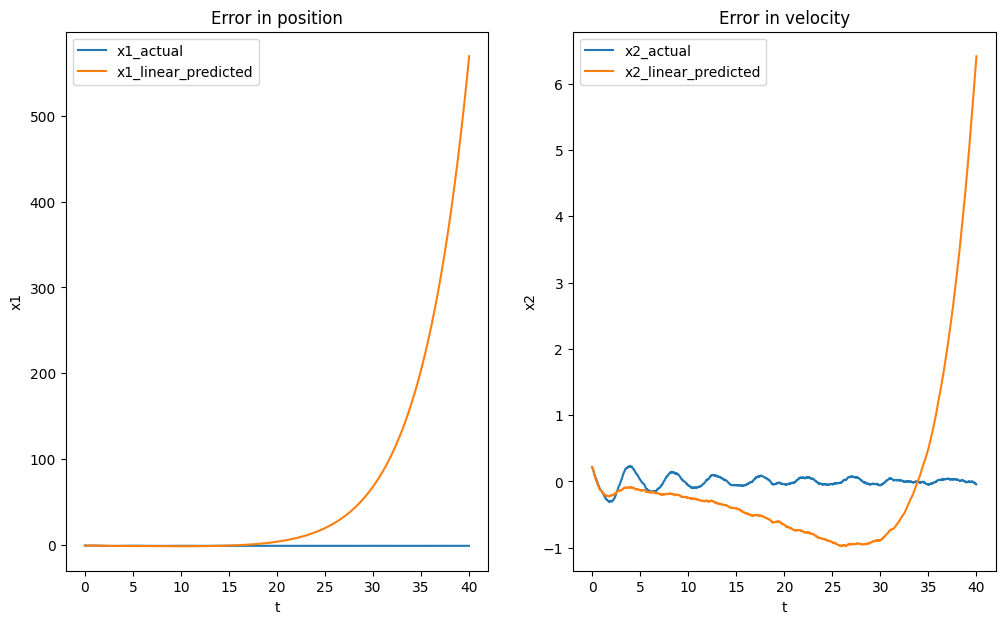

In [30]:
# plot dataset
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title("Error in position")
axs[1].set_title("Error in velocity")

axs[0].set(xlabel = 't', ylabel = 'x1')
axs[1].set(xlabel = 't', ylabel = 'x2')


axs[0].plot(T_test[:-1], X_unchanged[:,0], label = 'x1_actual')
if linear:
    axs[0].plot(T_test, x_est_lin[:,0], label = 'x1_linear_predicted')
if bilinear or BMPC:
    axs[0].plot(T_test, x_est_bilin[:,0], label = 'x1_bilinear_predicted')
axs[0].legend()

axs[1].plot(T_test[:-1], X_unchanged[:,1], label = 'x2_actual')
if linear:
    axs[1].plot(T_test, x_est_lin[:,1], label = 'x2_linear_predicted')
if bilinear or BMPC:
    axs[1].plot(T_test, x_est_bilin[:,1], label = 'x2_bilinear_predicted')
axs[1].legend()



# plt.savefig(file_img+'actual_vs_estimated.pdf')

In [31]:
"""Adaptation to correct poorly trained network"""

'Adaptation to correct poorly trained network'

In [32]:
from core.adapt_net_linear import AdaptNet_linear

In [33]:
# # initialize state matricies
# if linear:
#     z_adapt_lin = np.empty((n_obs_lin,num_snaps_test+1)).T   #lifted state
#     z_changed = np.empty((n_obs_lin,num_snaps_test)).T #actual lifted state
#     del_z_prime_lin = np.empty((n_obs_lin,num_snaps_test)).T
#     zu_actual_lin = np.empty((n_obs_lin*num_inputs,num_snaps_test)).T
#     x_adapt_est_lin = np.zeros((num_states,num_snaps_test+1)).T #estimated values
#     del_A_norm_lin = np.zeros((num_snaps_test,1))
#     del_B_norm_lin = np.zeros((num_snaps_test,1))
#     # initialize
#     z_adapt_lin[0,:] = z_lin[0,:]
#     x_adapt_est_lin[0,:] = x_unchanged[0,:]
#
#     #
#     adapt_window_lin = 1 #hyperparameter
#
#     adapt_net_params_lin = {}
#     adapt_net_params_lin['state_dim'] = num_states
#     adapt_net_params_lin['ctrl_dim'] = num_inputs
#     adapt_net_params_lin['lift_dim'] = net_params_lin['encoder_output_dim']
#     adapt_net_params_lin['optimizer'] = 'adam'
#     adapt_net_params_lin['lr'] = 1e-4 # 5e-4
#     adapt_net_params_lin['epochs'] = 8
#     adapt_net_params_lin['batch_size'] = adapt_window_lin
#     adapt_net_params_lin['l2_reg'] = 1e-3
#     adapt_net_params_lin['l1_reg'] = 1e-3
#     adapt_net_params_lin['first_obs_const'] = net_params_lin["first_obs_const"]
#     adapt_net_params_lin['override_C'] = net_params_lin["override_C"] # this makes the state a part of lifted state
#
#
#     del_A_lin = np.zeros_like(A_lin)
#     del_B_lin = np.zeros_like(B_lin)
#     for i in range(num_snaps_test):
#         # incorrect dynamics
#         z_lin[i,:] = lift(x_unchanged[i,:],model_koop_dnn_lin, net_params_lin)
#         z_adapt_lin[i+1,:] = np.matmul(z_adapt_lin[i,:],A_lin.T + del_A_lin.T) + np.matmul(u[i,:],B_lin.T + del_B_lin.T)
#
#         del_z_prime_lin[i,:] = z_lin[i,:] - z_adapt_lin[i,:]
#         if i < adapt_window_lin + 1:
#             del_A_lin = np.zeros_like(A_lin)
#             del_B_lin = np.zeros_like(B_lin)
#         else:
#             del_Z_prime_lin = del_z_prime_lin[i-adapt_window_lin:i,:].T
#             Z_lin = z_lin[i-(adapt_window_lin+1):i-1].T
#             U_lin = u[i-(adapt_window_lin+1):i-1].T
#
#             #invoke neural net for adapation
#             adapt_network_lin = AdaptNet_linear(adapt_net_params_lin)
#             adapt_network_lin.model_pipeline(Z_lin, U_lin, del_Z_prime_lin, print_epoch = True)
#
#             del_A_lin, del_B_lin = adapt_network_lin.get_del_matrices()
#
#         del_A_norm_lin[i] = np.linalg.norm(del_A_lin)
#         del_B_norm_lin[i] = np.linalg.norm(del_B_lin)
#
#         # adapted model
#         z_adapt_lin[i+1,:] = np.matmul(z_adapt_lin[i,:], A_lin.T + del_A_lin.T) + np.matmul(u[i,:], (B_lin.T + del_B_lin.T ))
#         x_adapt_est_lin[i+1,:] = np.matmul(z_adapt_lin[i+1,:],C_lin.T)


In [34]:
# # initialize state matricies
# if bilinear:
#     z_adapt_bilin = np.empty((n_obs_lin,num_snaps_test+1)).T   #lifted state
#     del_z_prime_bilin = np.empty((n_obs_lin,num_snaps_test)).T
#     zu_bilin = np.empty((n_obs_lin*num_inputs,num_snaps_test)).T
#     x_adapt_est_bilin = np.zeros((num_states,num_snaps_test+1)).T #estimated values
#     del_A_norm_bilin = np.zeros((num_snaps_test,1))
#     del_B_norm_bilin = np.zeros((num_snaps_test,1))
#     # initialize
#     z_adapt_bilin[0,:] = z_bilin[0,:]
#     x_adapt_est_bilin[0,:] = x_unchanged[0,:]
#
#     adapt_window_bilin = 1 #hyperparameter
#
#     adapt_net_params_bilin = {}
#     adapt_net_params_bilin['state_dim'] = num_states
#     adapt_net_params_bilin['ctrl_dim'] = num_inputs
#     adapt_net_params_bilin['lift_dim'] = net_params_bilin['encoder_output_dim']
#     adapt_net_params_bilin['optimizer'] = 'adam'
#     adapt_net_params_bilin['lr'] = 1e-4 # 5e-4
#     adapt_net_params_bilin['epochs'] = 8
#     adapt_net_params_bilin['batch_size'] = adapt_window_bilin
#     adapt_net_params_bilin['l2_reg'] = 1e-3
#     adapt_net_params_bilin['l1_reg'] = 1e-3
#     adapt_net_params_bilin['first_obs_const'] = net_params_bilin["first_obs_const"]
#     adapt_net_params_bilin['override_C'] = net_params_bilin["override_C"] # this makes the state a part of lifted state
#
#
#     del_A_bilin = np.zeros_like(A_bilin)
#     del_B_bilin = np.zeros_like(B_bilin)
#     for i in range(num_snaps_test):
#         # incorrect dynamics
#         z_bilin[i,:] = lift(x_unchanged[i,:],model_koop_dnn_bilin, net_params_bilin)
#         zu_bilin[i,:] = np.kron(u[i,:],z_bilin[i,:])
#         z_adapt_bilin[i+1,:] = np.matmul(z_adapt_bilin[i,:],A_bilin.T + del_A_bilin.T) + np.matmul(zu_bilin[i,:],B_bilin.T + del_B_bilin.T)
#
#         del_z_prime_bilin[i,:] = z_bilin[i,:] - z_adapt_bilin[i,:]
#         if i < adapt_window_bilin + 1:
#             del_A_bilin = np.zeros_like(A_bilin)
#             del_B_bilin = np.zeros_like(B_bilin)
#         else:
#             del_Z_prime_bilin = del_z_prime_bilin[i-adapt_window_bilin:i,:].T
#             Z_bilin = z_bilin[i-(adapt_window_bilin+1):i-1].T
#             ZU_bilin = zu_bilin[i-(adapt_window_bilin+1):i-1].T
#
#             #invoke neural net for adapation
#             adapt_network_bilin = AdaptNet(adapt_net_params_bilin)
#             adapt_network_bilin.model_pipeline(Z_bilin, ZU_bilin, del_Z_prime_bilin, print_epoch = True)
#
#             del_A_bilin, del_B_bilin = adapt_network_bilin.get_del_matrices()
#
#         del_A_norm_bilin[i] = np.linalg.norm(del_A_bilin)
#         del_B_norm_bilin[i] = np.linalg.norm(del_B_bilin)
#
#         # adapted model
#         z_adapt_bilin[i+1,:] = np.matmul(z_adapt_bilin[i,:], A_bilin.T + del_A_bilin.T) + np.matmul(np.kron(u[i,:],z_adapt_bilin[i,:]), (B_bilin.T + del_B_bilin.T ))
#         x_adapt_est_bilin[i+1,:] = np.matmul(z_adapt_bilin[i+1,:],C_bilin.T)


In [35]:
# # plot dataset
# fig, axs = plt.subplots(1,2,figsize=(12,7))
# axs[0].set_title("Error in position")
# axs[1].set_title("Error in velocity")
#
# axs[0].set(xlabel = 't', ylabel = 'x1')
# axs[1].set(xlabel = 't', ylabel = 'x2')
#
#
# axs[0].plot(T_test[:-1], X_unchanged[:,0], label = 'x1_actual')
# if linear:
#     file_image = 'saved_models/'+system+"/"+ 'linear'+'/'+'model_correction'+'/'
#     axs[0].plot(T_test, x_adapt_est_lin[:,0], label = 'x1_linear_predicted (adapt)')
#     axs[0].plot(T_test, x_est_lin[:,0], label = 'x1_linear_predicted (noadapt)')
# if bilinear:
#     file_image = 'saved_models/'+system+"/"+ 'bilinear'+'/'+'model_correction'+'/'
#     axs[0].plot(T_test, x_adapt_est_bilin[:,0], label = 'x1_bilinear_predicted (adapt)')
#     axs[0].plot(T_test, x_est_bilin[:,0], label = 'x1_bilinear_predicted (noadapt)')
# axs[0].legend()
#
# axs[1].plot(T_test[:-1], X_unchanged[:,1], label = 'x2_actual')
# if linear:
#     axs[1].plot(T_test, x_adapt_est_lin[:,1], label = 'x2_linear_predicted (adapt)')
#     axs[1].plot(T_test, x_est_lin[:,1], label = 'x2_linear_predicted (noadapt)')
# if bilinear:
#     axs[1].plot(T_test, x_adapt_est_bilin[:,1], label = 'x2_bilinear_predicted (adapt)')
#     axs[1].plot(T_test, x_est_bilin[:,1], label = 'x2_bilinear_predicted (noadapt)')
# axs[1].legend()
#
# plt.savefig(file_image+'adapt_model_correction.pdf')

In [36]:
# # plot dataset
# fig, axs = plt.subplots(1,2,figsize=(12,7))
# axs[0].set_title("Error in position")
# axs[1].set_title("Error in velocity")
#
# axs[0].set(xlabel = 't', ylabel = 'x1')
# axs[1].set(xlabel = 't', ylabel = 'x2')
#
#
# if linear:
#     axs[0].plot(T_test[:-1], del_A_norm_lin, label = 'del_A_norm_lin')
# if bilinear:
#     axs[0].plot(T_test[:-1], del_A_norm_bilin, label = 'del_A_norm_bilin')
# axs[0].legend()
#
#
# if linear:
#     axs[1].plot(T_test[:-1], del_B_norm_lin, label = 'del_B_norm_lin')
# if bilinear:
#     axs[1].plot(T_test[:-1], del_B_norm_bilin, label = 'del_B_norm_bilin')
# axs[1].legend()
#
# plt.savefig(file_image+'del_norm.pdf')

In [37]:
# # plot dataset
#
#
#
# fig, axs = plt.subplots(1,2,figsize=(12,7))
# axs[0].set_title("Error in position")
# axs[1].set_title("Error in velocity")
#
# axs[0].set(xlabel = 't', ylabel = 'x1')
# axs[1].set(xlabel = 't', ylabel = 'x2')
#
#
# if linear:
#     error_adapt_lin = x_adapt_est_lin[:-1,:]-x_unchanged
#     axs[0].plot(T_test[:-1], error_adapt_lin[:,0], label = 'x1_error_linear')
# if bilinear:
#     error_adapt_bilin = x_adapt_est_bilin[:-1,:]-x_unchanged
#     axs[0].plot(T_test[:-1], error_adapt_bilin[:,0], label = 'x1_error_bilinear')
# axs[0].legend()
#
# #
# if linear:
#     axs[1].plot(T_test[:-1], error_adapt_lin[:,1], label = 'x2_error_linear')
# if bilinear:
#     axs[1].plot(T_test[:-1], error_adapt_lin[:,1], label = 'x2_error_bilinear')
# axs[1].legend()
#
# plt.savefig(file_image+'adapt_error_model.pdf')

In [38]:
"""Adaptation Network to adapt to changed dynamics"""

'Adaptation Network to adapt to changed dynamics'

In [39]:
# # initialize state matricies
# if linear:
#     z_adapt_lin = np.empty((n_obs_lin,num_snaps_test+1)).T   #lifted state
#     z_changed = np.empty((n_obs_lin,num_snaps_test)).T #actual lifted state
#     del_z_prime_lin = np.empty((n_obs_lin,num_snaps_test)).T
#     zu_actual_lin = np.empty((n_obs_lin*num_inputs,num_snaps_test)).T
#     x_adapt_est_lin = np.zeros((num_states,num_snaps_test+1)).T #estimated values
#     del_A_norm_lin = np.zeros((num_snaps_test,1))
#     del_B_norm_lin = np.zeros((num_snaps_test,1))
#     # initialize
#     z_adapt_lin[0,:] = z_lin[0,:]
#     x_adapt_est_lin[0,:] = x_changed[0,:]
#
#     #
#     adapt_window_lin = 1 #hyperparameter
#
#     adapt_net_params_lin = {}
#     adapt_net_params_lin['state_dim'] = num_states
#     adapt_net_params_lin['ctrl_dim'] = num_inputs
#     adapt_net_params_lin['lift_dim'] = net_params_bilin['encoder_output_dim']
#     adapt_net_params_lin['optimizer'] = 'adam'
#     adapt_net_params_lin['lr'] = 2e-4 # 5e-4
#     adapt_net_params_lin['epochs'] = 10
#     adapt_net_params_lin['batch_size'] = adapt_window_lin
#     adapt_net_params_lin['l2_reg'] = 1e-3
#     adapt_net_params_lin['l1_reg'] = 1e-3
#     adapt_net_params_lin['first_obs_const'] = net_params_bilin["first_obs_const"]
#     adapt_net_params_lin['override_C'] = net_params_bilin["override_C"] # this makes the state a part of lifted state
#
#
#     del_A_lin = np.zeros_like(A_lin)
#     del_B_lin = np.zeros_like(B_lin)
#     for i in range(num_snaps_test):
#         # incorrect dynamics
#         z_lin[i,:] = lift(x_changed[i,:],model_koop_dnn_lin, net_params_lin)
#         z_adapt_lin[i+1,:] = np.matmul(z_adapt_lin[i,:],A_lin.T + del_A_lin.T) + np.matmul(u[i,:],B_lin.T + del_B_lin.T)
#
#         del_z_prime_lin[i,:] = z_lin[i,:] - z_adapt_lin[i,:]
#         if i < adapt_window_lin + 1:
#             del_A_lin = np.zeros_like(A_lin)
#             del_B_lin = np.zeros_like(B_lin)
#         else:
#             del_Z_prime_lin = del_z_prime_lin[i-adapt_window_lin:i,:].T
#             Z_lin = z_lin[i-(adapt_window_lin+1):i-1].T
#             U_lin = u[i-(adapt_window_lin+1):i-1].T
#
#             #invoke neural net for adapation
#             adapt_network_lin = AdaptNet_linear(adapt_net_params_lin)
#             adapt_network_lin.model_pipeline(Z_lin, U_lin, del_Z_prime_lin, print_epoch = True)
#
#             del_A_lin, del_B_lin = adapt_network_lin.get_del_matrices()
#
#         del_A_norm_lin[i] = np.linalg.norm(del_A_lin)
#         del_B_norm_lin[i] = np.linalg.norm(del_B_lin)
#
#         # adapted model
#         z_adapt_lin[i+1,:] = np.matmul(z_adapt_lin[i,:], A_lin.T + del_A_lin.T) + np.matmul(u[i,:], (B_lin.T + del_B_lin.T ))
#         x_adapt_est_lin[i+1,:] = np.matmul(z_adapt_lin[i+1,:],C_lin.T)


In [40]:
# # initialize state matricies
# if bilinear:
#     z_adapt_bilin = np.empty((n_obs_lin,num_snaps_test+1)).T   #lifted state
#     del_z_prime_bilin = np.empty((n_obs_lin,num_snaps_test)).T
#     zu_bilin = np.empty((n_obs_lin*num_inputs,num_snaps_test)).T
#     x_adapt_est_bilin = np.zeros((num_states,num_snaps_test+1)).T #estimated values
#     del_A_norm_bilin = np.zeros((num_snaps_test,1))
#     del_B_norm_bilin = np.zeros((num_snaps_test,1))
#     # initialize
#     z_adapt_bilin[0,:] = z_bilin[0,:]
#     x_adapt_est_bilin[0,:] = x_changed[0,:]
#
#     adapt_window_bilin = 1 #hyperparameter
#
#     adapt_net_params_bilin = {}
#     adapt_net_params_bilin['state_dim'] = num_states
#     adapt_net_params_bilin['ctrl_dim'] = num_inputs
#     adapt_net_params_bilin['lift_dim'] = net_params_bilin['encoder_output_dim']
#     adapt_net_params_bilin['optimizer'] = 'adam'
#     adapt_net_params_bilin['lr'] = 2e-4 # 5e-4
#     adapt_net_params_bilin['epochs'] = 8
#     adapt_net_params_bilin['batch_size'] = adapt_window_bilin
#     adapt_net_params_bilin['l2_reg'] = 1e-3
#     adapt_net_params_bilin['l1_reg'] = 1e-3
#     adapt_net_params_bilin['first_obs_const'] = net_params_bilin["first_obs_const"]
#     adapt_net_params_bilin['override_C'] = net_params_bilin["override_C"] # this makes the state a part of lifted state
#
#
#     del_A_bilin = np.zeros_like(A_bilin)
#     del_B_bilin = np.zeros_like(B_bilin)
#     for i in range(num_snaps_test):
#         # incorrect dynamics
#         z_bilin[i,:] = lift(x_changed[i,:],model_koop_dnn_bilin, net_params_bilin)
#         zu_bilin[i,:] = np.kron(u[i,:],z_bilin[i,:])
#         z_adapt_bilin[i+1,:] = np.matmul(z_adapt_bilin[i,:],A_bilin.T + del_A_bilin.T) + np.matmul(zu_bilin[i,:],B_bilin.T + del_B_bilin.T)
#
#         del_z_prime_bilin[i,:] = z_bilin[i,:] - z_adapt_bilin[i,:]
#         if i < adapt_window_bilin + 1:
#             del_A_bilin = np.zeros_like(A_bilin)
#             del_B_bilin = np.zeros_like(B_bilin)
#         else:
#             del_Z_prime_bilin = del_z_prime_bilin[i-adapt_window_bilin:i,:].T
#             Z_bilin = z_bilin[i-(adapt_window_bilin+1):i-1].T
#             ZU_bilin = zu_bilin[i-(adapt_window_bilin+1):i-1].T
#
#             #invoke neural net for adapation
#             adapt_network_bilin = AdaptNet(adapt_net_params_bilin)
#             adapt_network_bilin.model_pipeline(Z_bilin, ZU_bilin, del_Z_prime_bilin, print_epoch = True)
#
#             del_A_bilin, del_B_bilin = adapt_network_bilin.get_del_matrices()
#
#         del_A_norm_bilin[i] = np.linalg.norm(del_A_bilin)
#         del_B_norm_bilin[i] = np.linalg.norm(del_B_bilin)
#
#         # adapted model
#         z_adapt_bilin[i+1,:] = np.matmul(z_adapt_bilin[i,:], A_bilin.T + del_A_bilin.T) + np.matmul(np.kron(u[i,:],z_adapt_bilin[i,:]), (B_bilin.T + del_B_bilin.T ))
#         x_adapt_est_bilin[i+1,:] = np.matmul(z_adapt_bilin[i+1,:],C_bilin.T)


In [41]:
# # plot dataset
# fig, axs = plt.subplots(1,2,figsize=(12,7))
# axs[0].set_title("Error in position")
# axs[1].set_title("Error in velocity")
#
# axs[0].set(xlabel = 't', ylabel = 'x1')
# axs[1].set(xlabel = 't', ylabel = 'x2')
#
#
# axs[0].plot(T_test[:-1], X_changed[:,0], label = 'x1_actual')
# if linear:
#     axs[0].plot(T_test, x_adapt_est_lin[:,0], label = 'x1_linear_predicted')
# if bilinear:
#     axs[0].plot(T_test, x_adapt_est_bilin[:,0], label = 'x1_bilinear_predicted')
# axs[0].legend()
#
# axs[1].plot(T_test[:-1], X_changed[:,1], label = 'x2_actual')
# if linear:
#     axs[1].plot(T_test, x_adapt_est_lin[:,1], label = 'x2_linear_predicted')
# if bilinear:
#     axs[1].plot(T_test, x_adapt_est_bilin[:,1], label = 'x2_bilinear_predicted')
# axs[1].legend()
#
# # if dyn_pars['non_parms']:
# #     if linear:
# #         file_img = 'saved_models/'+system+'/linear/'+'nonparametric'+'/'+str(curve)+'/'
# #     plt.savefig(file_img+'adapt_model_correction.pdf')
# # else:
# #     plt.savefig(file_img+'adapt_model_correction.pdf')

In [42]:
# # plot dataset
# fig, axs = plt.subplots(1,2,figsize=(12,7))
# axs[0].set_title("Error in position")
# axs[1].set_title("Error in velocity")
#
# axs[0].set(xlabel = 't', ylabel = 'x1')
# axs[1].set(xlabel = 't', ylabel = 'x2')
#
#
# if linear:
#     axs[0].plot(T_test[:-1], del_A_norm_lin, label = 'x1_linear_predicted')
# if bilinear:
#     axs[0].plot(T_test[:-1], del_A_norm_bilin, label = 'x1_bilinear_predicted')
# axs[0].legend()
#
#
# if linear:
#     axs[1].plot(T_test[:-1], del_B_norm_lin, label = 'x2_linear_predicted')
# if bilinear:
#     axs[1].plot(T_test[:-1], del_B_norm_bilin, label = 'x2_bilinear_predicted')
# axs[1].legend()
#
# # plt.savefig(file_img+'del_norm_changed.pdf')

In [43]:
# # plot dataset
# fig, axs = plt.subplots(1,2,figsize=(12,7))
# axs[0].set_title("Error in position")
# axs[1].set_title("Error in velocity")
#
# axs[0].set(xlabel = 't', ylabel = 'x1')
# axs[1].set(xlabel = 't', ylabel = 'x2')
#
#
# if linear:
#     error_adapt_lin = x_adapt_est_lin[:-1,:]-x_changed
#     axs[0].plot(T_test[:-1], error_adapt_lin[:,0], label = 'x1_error_linear')
# if bilinear:
#     error_adapt_bilin = x_adapt_est_bilin[:-1,:]-x_changed
#     axs[0].plot(T_test[:-1], error_adapt_bilin[:,0], label = 'x1_error_bilinear')
# axs[0].legend()
#
# #
# if linear:
#     axs[1].plot(T_test[:-1], error_adapt_lin[:,1], label = 'x2_error_linear')
# if bilinear:
#     axs[1].plot(T_test[:-1], error_adapt_bilin[:,1], label = 'x2_error_bilinear')
# axs[1].legend()
# #
# # plt.savefig(file_img+'adapt_error_changed.pdf')

In [44]:
"""Simultaneous adaptation and control"""

'Simultaneous adaptation and control'

In [45]:
from control_files.nmpc_osqp_adapt import NonlinearMPCController
from control_files.bmpc_osqp_adapt import bilinearMPCController
from dynamics.learned_models_control.bilinear_dynamics import bilinear_Dynamics
from dynamics.learned_models_control.linear_dynamics import linear_Dynamics
from dynamics.learned_models_control.BMPC_dynamics import BMPC_Dynamics
import scipy

In [46]:
from dynamics.learned_models_control.duff_adapt import Duff_adapt
from dynamics.learned_models_control.vander_adapt import Vander_adapt
from paths import path_pars
import time

In [47]:
T_traj = 60
start_offset = 0
# curve = "sinusoidal"
# curve = 'curve1'
# curve = 'curve2'
# curve = 'curve3'
curve = 'curve4'


t_eval = np.arange(0, T_traj, dt)                       # Simulation time points, closed loop
traj_length = t_eval.size
x_ref = np.empty((num_states,traj_length+1))
for i in range(traj_length+1):
    x_ref[:,i] = 1.5*path_pars(i*dt, curve)

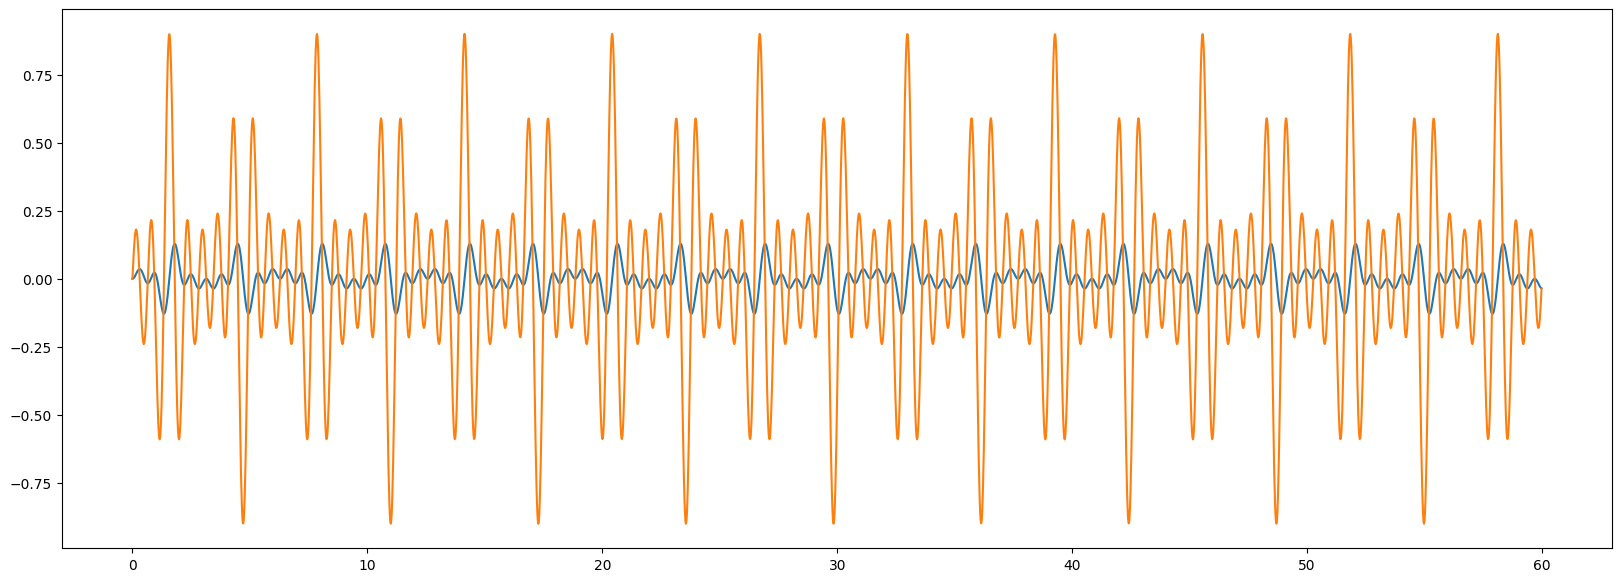

In [48]:
plt.figure(figsize=(20, 7))
plt.plot(t_eval,x_ref[0,:-1])
plt.plot(t_eval,x_ref[1,:-1])
plt.show()

In [49]:
begin_linear_noadapt = time.time()
if linear:

    solver_settings = {}
    solver_settings['gen_embedded_ctrl'] = False
    solver_settings['warm_start'] = True
    solver_settings['polish'] = True
    solver_settings['polish_refine_iter'] = 6
    solver_settings['scaling'] = True
    solver_settings['adaptive_rho'] = False
    solver_settings['check_termination'] = 25
    solver_settings['max_iter'] = 1000
    solver_settings['eps_abs'] = 1e-6
    solver_settings['eps_rel'] = 1e-6
    solver_settings['eps_prim_inf'] = 1e-4
    solver_settings['eps_dual_inf'] = 1e-4
    solver_settings['linsys_solver'] = 'qdldl'

    #controller that works on old model (unadapted)
    N_lin_noadapt = 15 #length of horizon
    Q_mpc_lin_noadapt = 16*scipy.sparse.diags(np.ones(num_states))                       # State penalty matrix, trajectory generation
    QN_mpc_lin_noadapt = 20*scipy.sparse.diags(np.ones(num_states))         # Final state penalty matrix, trajectory generation
    R_mpc_lin_noadapt = 0.05*scipy.sparse.eye(num_inputs)                       # Actuation penalty matrix, trajectory generation
    R0_mpc_lin_noadapt = scipy.sparse.csc_matrix(np.zeros(num_inputs))

    max_iter_lin = 1

    xmax_lin_noadapt = 20*np.ones((num_states))                          # State constraints, trajectory generation
    xmin_lin_noadapt = -xmax_lin_noadapt
    umax_lin_noadapt = 20*np.ones((num_inputs))
    umin_lin_noadapt = -umax_lin_noadapt

    xt_lin_noadapt = np.empty((traj_length+1, num_states))
    xt_actual_lin_noadapt = np.empty((traj_length+1, num_states))
    xt_lin_noadapt[0,:] = xt_actual_lin_noadapt[0,:] = start_offset + x_ref[:,0]

    x_init_lin_noadapt = np.linspace(xt_lin_noadapt[0,:], xt_lin_noadapt[0,:], N_lin_noadapt+1)
    u_init_lin_noadapt = 1*np.ones((num_inputs, N_lin_noadapt)).T

    n_lift = A_lin.shape[0]
    z_init_lin_noadapt = np.empty((N_lin_noadapt+1, n_lift))
    z0 = lift(xt_lin_noadapt[0,:], model_koop_dnn_lin, net_params_lin)
    for i in range(N_lin_noadapt+1):
        z_init_lin_noadapt[i,:] = lift(x_init_lin_noadapt[i,:], model_koop_dnn_lin, net_params_lin)

    linear_model_no_adapt = linear_Dynamics(scipy.sparse.csc_matrix(A_lin),scipy.sparse.csc_matrix(B_lin), C_lin)
    controller_nmpc_lin_noadapt = NonlinearMPCController(linear_model_no_adapt, N_lin_noadapt, dt, umin_lin_noadapt, umax_lin_noadapt, xmin_lin_noadapt, xmax_lin_noadapt, Q_mpc_lin_noadapt, R_mpc_lin_noadapt, QN_mpc_lin_noadapt, solver_settings)
    controller_nmpc_lin_noadapt.construct_controller(z_init_lin_noadapt, u_init_lin_noadapt, x_ref[:,0])
    # controller_nmpc_noadapt.trajectory_tracking(xt[0,:], z0, x_ref.T, max_iter)

    xt_lin_noadapt = np.empty((num_states,traj_length+1)).T
    xt_new_lin_noadapt = np.empty((num_states,traj_length+1)).T
    xt_lin_noadapt[0,:] = xt_new_lin_noadapt[0,:] = xt_lin_noadapt[0,:]
    u_lin_noadapt = np.empty((num_inputs, traj_length)).T
    z_lin_noadapt = np.empty((n_obs_lin, traj_length+1)).T

    for k in range(traj_length):
        # incorrect dynamics
        z_lin_noadapt[k,:] = lift(xt_actual_lin_noadapt[k,:], model_koop_dnn_lin, net_params_lin)

        controller_nmpc_lin_noadapt.solve_to_convergence(x_ref[:,k+1], z_lin_noadapt[k,:], controller_nmpc_lin_noadapt.z_init, controller_nmpc_lin_noadapt.u_init, max_iter = max_iter_lin, eps = 1e-3)
        controller_nmpc_lin_noadapt.update_initial_guess_()
        u_lin_noadapt[k,:] = controller_nmpc_lin_noadapt.cur_u[0,:]

        # adapted model
        xt_lin_noadapt[k+1,:] = np.matmul(controller_nmpc_lin_noadapt.z_N0, C_lin.T)

        if system == "Duffing":
            _, xt_actual_lin_noadapt[k+1,:] = Duff_adapt(dt, xt_actual_lin_noadapt[k,:], u_lin_noadapt[k,:], num_states, dyn_pars)
        elif system=="Vander":
            _, xt_actual_lin_noadapt[k+1,:] = Vander_adapt(dt, xt_actual_lin_noadapt[k,:], u_lin_noadapt[k,:], num_states, dyn_pars)

end_linear_noadapt = time.time()
time_linear_noadapt = (end_linear_noadapt - begin_linear_noadapt)/traj_length

In [50]:
begin_bilinear_noadapt = time.time()
if bilinear or BMPC:

    solver_settings = {}
    solver_settings['gen_embedded_ctrl'] = False
    solver_settings['warm_start'] = True
    solver_settings['polish'] = True
    solver_settings['polish_refine_iter'] = 6
    solver_settings['scaling'] = True
    solver_settings['adaptive_rho'] = False
    solver_settings['check_termination'] = 25
    solver_settings['max_iter'] = 1000
    solver_settings['eps_abs'] = 1e-6
    solver_settings['eps_rel'] = 1e-6
    solver_settings['eps_prim_inf'] = 1e-4
    solver_settings['eps_dual_inf'] = 1e-4
    solver_settings['linsys_solver'] = 'qdldl'

    #controller that works on old model (unadapted)
    N_bilin_noadapt = 20 #length of horizon
    Q_mpc_bilin_noadapt = 300*scipy.sparse.diags(np.ones(num_states))                       # State penalty matrix, trajectory generation
    QN_mpc_bilin_noadapt = 1e3*scipy.sparse.diags(np.ones(num_states))         # Final state penalty matrix, trajectory generation
    R_mpc_bilin_noadapt = 0.02*scipy.sparse.eye(num_inputs)                       # Actuation penalty matrix, trajectory generation
    R0_mpc_bilin_noadapt = scipy.sparse.csc_matrix(np.zeros(num_inputs))

    if BMPC:
        max_iter_bilin = 1
    elif bilinear:
        max_iter_bilin = 100

    xmax_bilin_noadapt = 5*np.ones((num_states))                          # State constraints, trajectory generation
    xmin_bilin_noadapt = -xmax_bilin_noadapt
    umax_bilin_noadapt = 100*np.ones((num_inputs))
    umin_bilin_noadapt = -umax_bilin_noadapt


    xt_bilin_noadapt = np.empty((traj_length+1, num_states))
    xt_actual_bilin_noadapt = np.empty((traj_length+1, num_states))
    xt_bilin_noadapt[0,:] = xt_actual_bilin_noadapt[0,:] = x_ref[:,0]

    x_init_bilin_noadapt = np.linspace(xt_bilin_noadapt[0,:], xt_bilin_noadapt[0,:], N_bilin_noadapt+1)
    u_init_bilin_noadapt = 1*np.ones((num_inputs, N_bilin_noadapt)).T

    n_lift = A_bilin.shape[0]
    z_init_bilin_noadapt = np.empty((N_bilin_noadapt+1, n_lift))
    z0 = lift(xt_bilin_noadapt[0,:], model_koop_dnn_bilin, net_params_bilin)
    for i in range(N_bilin_noadapt+1):
        z_init_bilin_noadapt[i,:] = lift(x_init_bilin_noadapt[i,:], model_koop_dnn_bilin, net_params_bilin)

    if bilinear:
        bilinear_model_no_adapt = bilinear_Dynamics(scipy.sparse.csc_matrix(A_bilin),scipy.sparse.csc_matrix(B_bilin), C_bilin)
        controller_nmpc_bilin_noadapt = NonlinearMPCController(bilinear_model_no_adapt, N_bilin_noadapt, dt, umin_bilin_noadapt, umax_bilin_noadapt, xmin_bilin_noadapt, xmax_bilin_noadapt, Q_mpc_bilin_noadapt, R_mpc_bilin_noadapt, QN_mpc_bilin_noadapt, solver_settings)
    elif BMPC:
        bilinear_model_no_adapt = BMPC_Dynamics(scipy.sparse.csc_matrix(A_bilin),scipy.sparse.csc_matrix(B_bilin), C_bilin)
        controller_nmpc_bilin_noadapt = bilinearMPCController(bilinear_model_no_adapt, N_bilin_noadapt, dt, umin_bilin_noadapt, umax_bilin_noadapt, xmin_bilin_noadapt, xmax_bilin_noadapt, Q_mpc_bilin_noadapt, R_mpc_bilin_noadapt, QN_mpc_bilin_noadapt, solver_settings)

    controller_nmpc_bilin_noadapt.construct_controller(z_init_bilin_noadapt, u_init_bilin_noadapt, x_ref[:,0])

    xt_bilin_noadapt = np.empty((num_states,traj_length+1)).T
    xt_new_bilin_noadapt = np.empty((num_states,traj_length+1)).T
    xt_bilin_noadapt[0,:] = xt_new_bilin_noadapt[0,:] = xt_bilin_noadapt[0,:]
    u_bilin_noadapt = np.empty((num_inputs, traj_length)).T
    z_bilin_noadapt = np.empty((n_obs_bilin, traj_length+1)).T

    for l in range(traj_length):
        # incorrect dynamics
        z_bilin_noadapt[l,:] = lift(xt_actual_bilin_noadapt[l,:], model_koop_dnn_bilin, net_params_bilin)

        controller_nmpc_bilin_noadapt.solve_to_convergence(x_ref[:,l+1], z_bilin_noadapt[l,:], controller_nmpc_bilin_noadapt.z_init, controller_nmpc_bilin_noadapt.u_init, max_iter = max_iter_bilin, eps = 1e-3)
        controller_nmpc_bilin_noadapt.update_initial_guess_()
        u_bilin_noadapt[l,:] = controller_nmpc_bilin_noadapt.cur_u[0,:]

        # adapted model
        xt_bilin_noadapt[l+1,:] = np.matmul(controller_nmpc_bilin_noadapt.z_N0, C_bilin.T)

        if system == "Duffing":
            _, xt_actual_bilin_noadapt[l+1,:] = Duff_adapt(dt, xt_actual_bilin_noadapt[l,:], u_bilin_noadapt[l,:], num_states, dyn_pars)
        elif system=="Vander":
            _, xt_actual_bilin_noadapt[l+1,:] = Vander_adapt(dt, xt_actual_bilin_noadapt[l,:], u_bilin_noadapt[l,:], num_states, dyn_pars)

end_bilinear_noadapt = time.time()
time_bilinear_noadapt = (end_linear_noadapt - begin_linear_noadapt)/traj_length

In [51]:
begin_bilinear_adapt = time.time()
if bilinear or BMPC:
    model_koop_dnn_bilin = torch.load(file_koop_bilinear)
    adapt_window_ctrl_bilin = 5 #hyperparameter

    adapt_params_control_bilin = {}
    adapt_params_control_bilin['state_dim'] = num_states
    adapt_params_control_bilin['ctrl_dim'] = num_inputs
    adapt_params_control_bilin['lift_dim'] = net_params_bilin["encoder_output_dim"]
    adapt_params_control_bilin['optimizer'] = 'adam'
    adapt_params_control_bilin['lr'] = 1e-5 # 5e-4
    adapt_params_control_bilin['epochs'] = 8
    adapt_params_control_bilin['batch_size'] = adapt_window_ctrl_bilin
    adapt_params_control_bilin['l2_reg'] = 5e-1
    adapt_params_control_bilin['l1_reg'] = 5e-1
    adapt_params_control_bilin['first_obs_const'] = net_params_bilin["first_obs_const"]
    adapt_params_control_bilin['override_C'] = net_params_bilin["override_C"] # this makes the state a part of lifted state

    del_A_ctrl_bilin = np.zeros_like(A_bilin)
    del_B_ctrl_bilin = np.zeros_like(B_bilin)

    if bilinear:
        bilinear_model_adapt = bilinear_Dynamics(scipy.sparse.csc_matrix(A_bilin),scipy.sparse.csc_matrix(B_bilin), C_bilin)
    if BMPC:
        bilinear_model_adapt = BMPC_Dynamics(scipy.sparse.csc_matrix(A_bilin),scipy.sparse.csc_matrix(B_bilin), C_bilin)

    solver_settings = {}
    solver_settings['gen_embedded_ctrl'] = False
    solver_settings['warm_start'] = True
    solver_settings['polish'] = True
    solver_settings['polish_refine_iter'] = 6
    solver_settings['scaling'] = True
    solver_settings['adaptive_rho'] = False
    solver_settings['check_termination'] = 25
    solver_settings['max_iter'] = 1000
    solver_settings['eps_abs'] = 1e-6
    solver_settings['eps_rel'] = 1e-6
    solver_settings['eps_prim_inf'] = 1e-4
    solver_settings['eps_dual_inf'] = 1e-4
    solver_settings['linsys_solver'] = 'qdldl'


    #Closed loop performance evaluation parameters:
    if BMPC:
        max_iter_bilin = 1
    elif bilinear:
        max_iter_bilin = 100

    N_bilin = 20 #length of horizon                      # Simulation time points, closed loop
    Q_mpc_bilin = 160*scipy.sparse.diags(np.ones(num_states))                       # State penalty matrix, trajectory generation
    QN_mpc_bilin = 200*scipy.sparse.diags(np.ones(num_states))         # Final state penalty matrix, trajectory generation
    if curve == "sinusoidal":
        R_mpc_bilin = 0.15*scipy.sparse.eye(num_inputs)
    else:                                                   # Actuation penalty matrix, trajectory generation
        R_mpc_bilin = 0.015*scipy.sparse.eye(num_inputs)
    R0_mpc_bilin = scipy.sparse.csc_matrix(np.zeros(num_inputs))

    # Design trajectory:
    xt_bilin = np.empty((traj_length+1, num_states))
    xt_bilin[0,:] = x_ref[:,0]                   # Initial value, closed loop trajectory


    xmax_bilin = xmax_bilin_noadapt                      # State constraints, trajectory generation
    xmin_bilin = xmin_bilin_noadapt
    umax_bilin = umax_bilin_noadapt
    umin_bilin = umin_bilin_noadapt

    # Define initial solution for SQP algorithm:
    x_init_bilin = np.linspace(xt_bilin[0,:], xt_bilin[0,:], N_bilin+1)
    u_init_bilin = 1*np.ones((num_inputs, N_bilin)).T

    n_lift_bilin = A_bilin.shape[0]
    z_init_bilin = np.empty((N_bilin+1, n_lift_bilin))
    z0_bilin = lift(xt_bilin[0,:], model_koop_dnn_bilin, net_params_bilin)
    for i in range(N_bilin+1):
        z_init_bilin[i,:] = lift(x_init_bilin[i,:], model_koop_dnn_bilin, net_params_bilin)

    # initialize state matricies
    u_ctrl_bilin = np.zeros((traj_length, num_inputs))
    z_new_dyn_bilin = np.empty((n_obs_bilin, traj_length+1)).T   #lifted state
    zt_old_dyn_bilin = np.empty((n_obs_bilin, traj_length+1)).T #actual lifted state
    zu_old_dyn_bilin = np.empty((n_obs_bilin * num_inputs, traj_length+1)).T #actual lifted state
    del_z_prime_ctrl_bilin = np.empty((n_obs_bilin, traj_length)).T
    x_new_dyn_bilin = np.empty((num_states, traj_length+1)).T #estimated values
    del_A_norm_ctrl_bilin = np.zeros((traj_length,1))
    del_B_norm_ctrl_bilin = np.zeros((traj_length,1))

    # initialize
    z_new_dyn_bilin[0,:] = zt_old_dyn_bilin[0,:] = z0_bilin
    x_new_dyn_bilin[0,:]  = xt_bilin[0,:]

    #controller that works on adapting model
    if bilinear:
        controller_nmpc_adapt = NonlinearMPCController(bilinear_model_adapt, N_bilin, dt, umin_bilin, umax_bilin, xmin_bilin, xmax_bilin, Q_mpc_bilin, R_mpc_bilin, QN_mpc_bilin, solver_settings)
    if BMPC:
        controller_nmpc_adapt = bilinearMPCController(bilinear_model_adapt, N_bilin, dt, umin_bilin, umax_bilin, xmin_bilin, xmax_bilin, Q_mpc_bilin, R_mpc_bilin, QN_mpc_bilin, solver_settings)

    controller_nmpc_adapt.construct_controller(z_init_bilin, u_init_bilin, x_ref[:,0])


    for j in range(traj_length):
        # incorrect dynamics
        z_new_dyn_bilin[j,:] = lift(x_new_dyn_bilin[j,:], model_koop_dnn_bilin, net_params_bilin)

        del_z_prime_ctrl_bilin[j,:] = z_new_dyn_bilin[j,:] - zt_old_dyn_bilin[j,:]
        zu_old_dyn_bilin[j,:] = np.kron(u_ctrl_bilin[j,:], zt_old_dyn_bilin[j,:])

        if j < adapt_window_ctrl_bilin + 1 :
            del_A = np.zeros_like(A_bilin)
            del_B = np.zeros_like(B_bilin)
        else:
            del_Z_prime = del_z_prime_ctrl_bilin[j-adapt_window_ctrl_bilin:j,:].T
            Z_old = zt_old_dyn_bilin[j-(adapt_window_ctrl_bilin+1):j-1].T
            ZU_old = zu_old_dyn_bilin[j-(adapt_window_ctrl_bilin+1):j-1].T

            #invoke neural net for adapation
            adapt_network = AdaptNet(adapt_params_control_bilin)
            adapt_network.model_pipeline(Z_old, ZU_old, del_Z_prime, print_epoch = True)
            del_A_ctrl_bilin, del_B_ctrl_bilin = adapt_network.get_del_matrices()

        del_A_norm_ctrl_bilin[j] = np.linalg.norm(del_A_ctrl_bilin)
        del_B_norm_ctrl_bilin[j] = np.linalg.norm(del_B_ctrl_bilin)

        bilinear_model_adapt.A = scipy.sparse.csc_matrix(bilinear_model_adapt.A.toarray() + del_A_ctrl_bilin)
        bilinear_model_adapt.B = scipy.sparse.csc_matrix(bilinear_model_adapt.B.toarray() + del_B_ctrl_bilin)

        controller_nmpc_adapt.solve_to_convergence(x_ref[:,j+1], zt_old_dyn_bilin[j,:], controller_nmpc_adapt.z_init, controller_nmpc_adapt.u_init, max_iter = max_iter_bilin, eps = 1e-3)
        controller_nmpc_adapt.update_initial_guess_()
        u_ctrl_bilin[j,:] = controller_nmpc_adapt.cur_u[0,:]

        # adapted model
        zt_old_dyn_bilin[j+1,:] = controller_nmpc_adapt.z_N0
        xt_bilin[j+1,:] = np.matmul(zt_old_dyn_bilin[j+1,:],C_bilin.T)


        if system == "Duffing":
            _, x_new_dyn_bilin[j+1,:] = Duff_adapt(dt, xt_bilin[j,:], u_ctrl_bilin[j,:], num_states, dyn_pars)
        elif system=="Vander":
            _, x_new_dyn_bilin[j+1,:] = Vander_adapt(dt, xt_bilin[j,:], u_ctrl_bilin[j,:], num_states, dyn_pars)

end_bilinear_adapt = time.time()
time_bilinear_adapt = (end_bilinear_adapt - begin_bilinear_adapt)/traj_length

In [52]:
A_lin

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-3.40717612e-03,  9.94672835e-01,  6.78813923e-03,
        -4.15899232e-03,  4.15459089e-03,  7.32640270e-03,
         1.13880001e-02],
       [ 3.84742767e-03, -1.52723445e-03,  1.00399804e+00,
         1.82927977e-02, -1.76049992e-02, -1.39238425e-02,
         1.35895666e-02],
       [-1.81597623e-03,  4.90329880e-03, -1.08424695e-02,
         9.91743684e-01,  1.01397391e-02,  9.39393975e-03,
        -1.38029670e-02],
       [-1.03526705e-04, -4.91361693e-03,  7.30742514e-03,
         5.93704265e-03,  9.88635957e-01, -1.82631868e-03,
         1.42227933e-02],
       [ 1.80874544e-03, -1.39530073e-03,  7.18728825e-03,
         9.62440390e-03, -9.18554235e-03,  9.93364453e-01,
         7.20104435e-03],
       [ 2.73722899e-03, -6.59417245e-04, -3.26925749e-03,
         3.11954506e-03, -3.82585591e-03, -1.13662938e-02,
         1.0052512

In [53]:
"""Adaptation and control"""
begin_linear_adapt = time.time()
if linear:
    model_koop_dnn_lin = torch.load(file_koop_linear)
    adapt_window_ctrl_lin = 10 #hyperparameter

    adapt_params_control_lin = {}
    adapt_params_control_lin['state_dim'] = num_states
    adapt_params_control_lin['ctrl_dim'] = num_inputs
    adapt_params_control_lin['lift_dim'] = net_params_lin["encoder_output_dim"]
    adapt_params_control_lin['optimizer'] = 'adam'
    adapt_params_control_lin['lr'] = 1e-5 # 5e-4
    adapt_params_control_lin['epochs'] = 8
    adapt_params_control_lin['batch_size'] = adapt_window_ctrl_lin
    adapt_params_control_lin['l2_reg'] = 5e-3
    adapt_params_control_lin['l1_reg'] = 5e-3
    adapt_params_control_lin['first_obs_const'] = net_params_lin["first_obs_const"]
    adapt_params_control_lin['override_C'] = net_params_lin["override_C"] # this makes the state a part of lifted state

    del_A_ctrl_lin = np.zeros_like(A_lin)
    del_B_ctrl_lin = np.zeros_like(B_lin)

    linear_model_adapt = linear_Dynamics(scipy.sparse.csc_matrix(A_lin),scipy.sparse.csc_matrix(B_lin), C_lin)

    solver_settings = {}
    solver_settings['gen_embedded_ctrl'] = False
    solver_settings['warm_start'] = True
    solver_settings['polish'] = True
    solver_settings['polish_refine_iter'] = 6
    solver_settings['scaling'] = True
    solver_settings['adaptive_rho'] = False
    solver_settings['check_termination'] = 25
    solver_settings['max_iter'] = 1000
    solver_settings['eps_abs'] = 1e-6
    solver_settings['eps_rel'] = 1e-6
    solver_settings['eps_prim_inf'] = 1e-4
    solver_settings['eps_dual_inf'] = 1e-4
    solver_settings['linsys_solver'] = 'qdldl'


    #Closed loop performance evaluation parameters:
    max_iter_lin = 1
    N_lin = 15 #length of horizon
    Q_mpc_lin = 16*scipy.sparse.diags(np.ones(num_states))                       # State penalty matrix, trajectory generation
    QN_mpc_lin = 20*scipy.sparse.diags(np.ones(num_states))         # Final state penalty matrix, trajectory generation
    R_mpc_lin = 0.05*scipy.sparse.eye(num_inputs)                                     # Actuation penalty matrix, trajectory generation
    R0_mpc_lin = 1*scipy.sparse.csc_matrix(np.zeros(num_inputs))

    # Design trajectory:
    xt_lin = np.empty((traj_length+1, num_states))
    xt_lin[0,:] = start_offset + x_ref[:,0]                   # Initial value, closed loop trajectory

    xmax_lin = xmax_lin_noadapt                        # State constraints, trajectory generation
    xmin_lin = xmin_lin_noadapt
    umax_lin = umax_lin_noadapt
    umin_lin = umin_lin_noadapt

    # Define initial solution for SQP algorithm:
    x_init_lin = np.linspace(xt_lin[0,:], xt_lin[0,:], N_lin+1)
    u_init_lin = 1*np.ones((num_inputs, N_lin)).T

    n_lift_lin = A_lin.shape[0]
    z_init_lin = np.empty((N_lin+1, n_lift_lin))
    z0_lin = lift(xt_lin[0,:], model_koop_dnn_lin, net_params_lin)
    for i in range(N_lin+1):
        z_init_lin[i,:] = lift(x_init_lin[i,:], model_koop_dnn_lin, net_params_lin)

    # initialize state matricies
    u_ctrl_lin = np.zeros((traj_length, num_inputs))
    z_new_dyn_lin = np.empty((n_obs_lin, traj_length+1)).T   #lifted state
    zt_old_dyn_lin = np.empty((n_obs_lin, traj_length+1)).T #actual lifted state
    del_z_prime_ctrl_lin = np.empty((n_obs_lin, traj_length)).T
    x_new_dyn_lin = np.empty((num_states, traj_length+1)).T #estimated values
    del_A_norm_ctrl_lin = np.zeros((traj_length,1))
    del_B_norm_ctrl_lin = np.zeros((traj_length,1))

    # initialize
    z_new_dyn_lin[0,:] = zt_old_dyn_lin[0,:] = z0_lin
    x_new_dyn_lin[0,:]  = xt_lin[0,:]

    #controller that works on adapting model
    controller_nmpc_adapt_lin = NonlinearMPCController(linear_model_adapt, N_lin, dt, umin_lin, umax_lin, xmin_lin, xmax_lin, Q_mpc_lin, R_mpc_lin, QN_mpc_lin, solver_settings)
    controller_nmpc_adapt_lin.construct_controller(z_init_lin, u_init_lin, x_ref[:,0])


    for i in range(traj_length):
        # incorrect dynamics
        z_new_dyn_lin[i,:] = lift(x_new_dyn_lin[i,:], model_koop_dnn_lin, net_params_lin)

        del_z_prime_ctrl_lin[i,:] = z_new_dyn_lin[i,:] - zt_old_dyn_lin[i,:]

        if i < adapt_window_ctrl_lin + 1 :
            del_A_ctrl_lin = np.zeros_like(A_lin)
            del_B_ctrl_lin = np.zeros_like(B_lin)
        else:
            del_Z_prime_ctrl_lin = del_z_prime_ctrl_lin[i-adapt_window_ctrl_lin:i,:].T
            Z_old_lin = zt_old_dyn_lin[i-(adapt_window_ctrl_lin+1):i-1].T
            U_old_lin = u_ctrl_lin[i-(adapt_window_ctrl_lin+1):i-1].T

            #invoke neural net for adapation
            adapt_network = AdaptNet_linear(adapt_params_control_lin)
            adapt_network.model_pipeline(Z_old_lin, U_old_lin, del_Z_prime_ctrl_lin, print_epoch = True)
            del_A_ctrl_lin, del_B_ctrl_lin = adapt_network.get_del_matrices()

        del_A_norm_ctrl_lin[i] = np.linalg.norm(del_A_ctrl_lin)
        del_B_norm_ctrl_lin[i] = np.linalg.norm(del_B_ctrl_lin)

        linear_model_adapt.A = scipy.sparse.csc_matrix(linear_model_adapt.A.toarray() + del_A_ctrl_lin)
        linear_model_adapt.B = scipy.sparse.csc_matrix(linear_model_adapt.B.toarray() + del_B_ctrl_lin)

        controller_nmpc_adapt_lin.solve_to_convergence(x_ref[:,i+1], z_new_dyn_lin[i,:], controller_nmpc_adapt_lin.z_init, controller_nmpc_adapt_lin.u_init, max_iter = max_iter_lin, eps = 1e-6)
        controller_nmpc_adapt_lin.update_initial_guess_()
        u_ctrl_lin[i,:] = controller_nmpc_adapt_lin.cur_u[0,:]

        # adapted model
        zt_old_dyn_lin[i+1,:] = controller_nmpc_adapt_lin.z_N0
        # xt_lin[i+1,:] = np.matmul(zt_old_dyn_lin[i+1,:],C_lin.T)

        if system == "Duffing":
            _, x_new_dyn_lin[i+1,:] = Duff_adapt(dt, x_new_dyn_lin[i,:], u_ctrl_lin[i,:], num_states, dyn_pars)
        elif system=="Vander":
            _, x_new_dyn_lin[i+1,:] = Vander_adapt(dt, x_new_dyn_lin[i,:], u_ctrl_lin[i,:], num_states, dyn_pars)

end_linear_adapt = time.time()
time_linear_adapt = (end_linear_adapt - begin_linear_adapt)/traj_length

KeyError: 'warm_start'

In [ ]:
i

In [54]:
if linear:
    file_img = 'saved_models/'+system+'/linear/'+str(percent_change)+'/'+str(curve)+'/'
    if dyn_pars['non_parms']:
        file_img = 'saved_models/'+system+'/linear/'+'nonparametric'+'/'+ str(dyn_pars['amp']) +'/'+str(curve)+'/'
    elif dyn_pars['noise']:
        file_img = 'saved_models/'+system+'/linear/'+'gaussian_noise'+'/'+ 'sd_' + str(dyn_pars['sd']) +'/'+str(curve)+'/'
if bilinear:
    file_img = 'saved_models/'+system+'/bilinear/'+str(percent_change)+'/'+str(curve)+'/'
    if dyn_pars['non_parms']:
        file_img = 'saved_models/'+system+'/bilinear/'+'nonparametric'+'/'+ str(dyn_pars['amp']) +'/'+str(curve)+'/'
    elif dyn_pars['noise']:
        file_img = 'saved_models/'+system+'/bilinear/'+'gaussian_noise'+'/'+ 'sd_' + str(dyn_pars['sd']) +'/'+str(curve)+'/'
elif BMPC:
    file_img = 'saved_models/'+system+'/BMPC/'+str(percent_change)+'/'+str(curve)+'/'
    if dyn_pars['non_parms']:
        file_img = 'saved_models/'+system+'/BMPC/'+'nonparametric'+'/'+ str(dyn_pars['amp']) +'/'+str(curve)+'/'
    elif dyn_pars['noise']:
        file_img = 'saved_models/'+system+'/BMPC/'+'gaussian_noise'+'/' + 'sd_' + str(dyn_pars['sd']) +'/'+str(curve)+'/'

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/Duffing/linear/20/curve4/adapt_model_states.pdf'

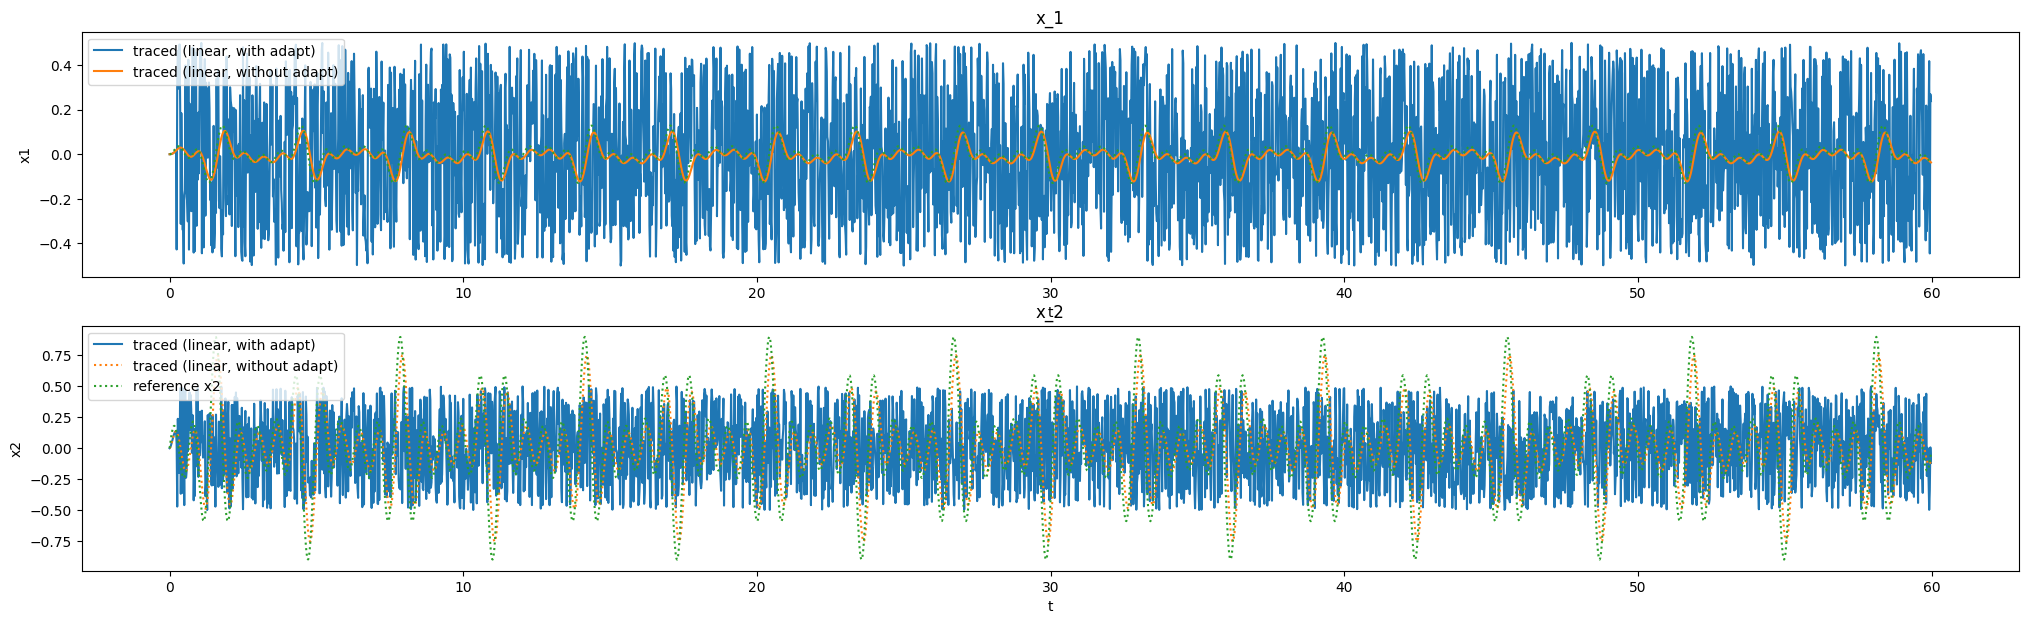

In [55]:
# plot dataset
fig, axs = plt.subplots(2,1,figsize=(25,7))
axs[0].set_title("x_1")
axs[1].set_title("x_2")

axs[0].set(xlabel = 't', ylabel = 'x1')
axs[1].set(xlabel = 't', ylabel = 'x2')


if linear:
    axs[0].plot(t_eval, x_new_dyn_lin[:-1,0],label ='traced (linear, with adapt)')
    axs[0].plot(t_eval, xt_actual_lin_noadapt[:-1,0], label='traced (linear, without adapt)')
if bilinear or BMPC:
    axs[0].plot(t_eval, x_new_dyn_bilin[:-1,0], label="traced (bilinear, with adapt)")
    axs[0].plot(t_eval, xt_actual_bilin_noadapt[:-1,0], label='traced (bilinear, without adapt)')
axs[0].legend()

if linear:
    axs[1].plot(t_eval, x_new_dyn_lin[:-1,1],label ='traced (linear, with adapt)')
    axs[1].plot(t_eval, xt_actual_lin_noadapt[:-1,1],":", label='traced (linear, without adapt)')
if bilinear or BMPC:
    axs[1].plot(t_eval, x_new_dyn_bilin[:-1,1], label="traced (bilinear, with adapt)")
    axs[1].plot(t_eval, xt_actual_bilin_noadapt[:-1,1], label='traced (bilinear, without adapt)')

axs[0].plot(t_eval, x_ref[0,:-1],':', label="reference x1")
axs[1].plot(t_eval, x_ref[1,:-1],':', label="reference x2")
axs[1].legend()
plt.savefig(file_img+'adapt_model_states.pdf')
plt.show()

In [ ]:
linear_model_adapt.A.toarray()-A_lin

In [ ]:
# plot dataset
fig, axs = plt.subplots(1,2,figsize=(25,7))
axs[0].set_title("del_A")
axs[1].set_title("del_B")

axs[0].set(xlabel = 't', ylabel = 'del_A')
axs[1].set(xlabel = 't', ylabel = 'del_B')

if linear:
    axs[0].plot(t_eval, del_A_norm_ctrl_lin, label = 'del_A_linear')
if bilinear or BMPC:
    axs[0].plot(t_eval, del_A_norm_ctrl_bilin, label = 'del_A_bilinear')
axs[0].legend()


if linear:
    axs[1].plot(t_eval, del_B_norm_ctrl_lin, label = 'del_B_linear')
if bilinear or BMPC:
    axs[1].plot(t_eval, del_B_norm_ctrl_bilin, label = 'del_B_bilinear')
axs[1].legend()

# plt.savefig(file_img+'del_norm_changed.pdf')
plt.show()

In [56]:
x_ref.shape

(2, 3001)

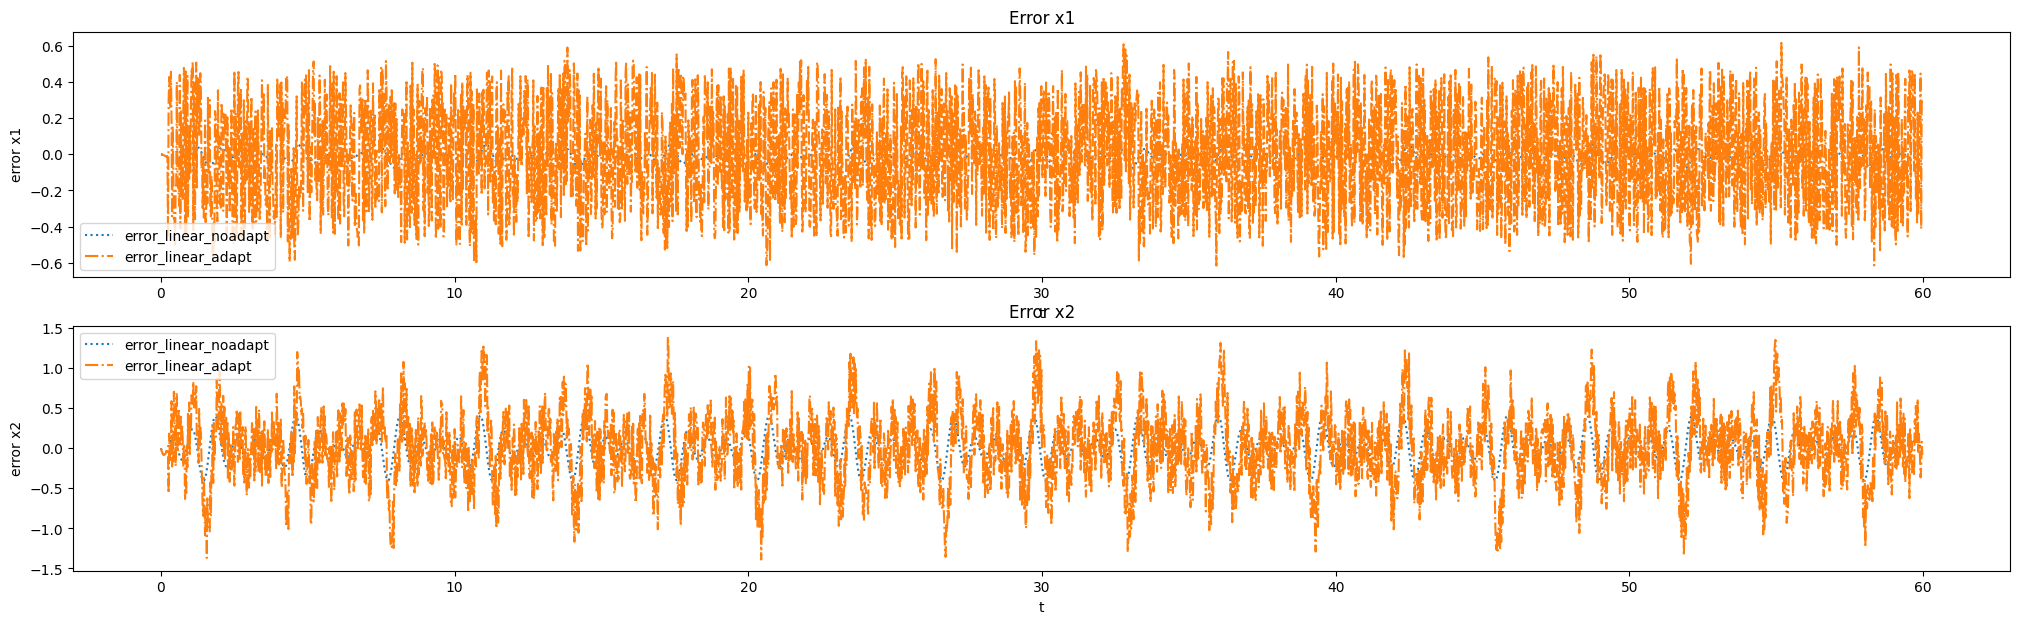

In [57]:

# plot dataset
fig, axs = plt.subplots(2,1,figsize=(25,7))
axs[0].set_title("Error x1")
axs[1].set_title("Error x2")

axs[0].set(xlabel = 't', ylabel = 'error x1')
axs[1].set(xlabel = 't', ylabel = 'error x2')


if linear:
    error_adapt_lin = x_new_dyn_lin - x_ref.T
    error_adapt_lin_norm = np.linalg.norm(error_adapt_lin)/np.max(x_ref)
    error_noadapt_lin = xt_actual_lin_noadapt - x_ref.T
    error_noadapt_lin_norm = np.linalg.norm(error_noadapt_lin)/np.max(x_ref)

    axs[0].plot(t_eval, error_noadapt_lin[:-1,0],":", label = 'error_linear_noadapt')
    axs[0].plot(t_eval, error_adapt_lin[:-1,0],"-.", label = 'error_linear_adapt')

    axs[1].plot(t_eval, error_noadapt_lin[:-1,1],":", label = 'error_linear_noadapt')
    axs[1].plot(t_eval, error_adapt_lin[:-1,1],'-.', label = 'error_linear_adapt')
if bilinear or BMPC:
    error_adapt_bilin = xt_bilin - x_ref.T
    error_noadapt_bilin = xt_actual_bilin_noadapt - x_ref.T

    error_adapt_bilin_norm = np.linalg.norm(error_adapt_bilin)/error_adapt_bilin.shape[0]
    error_noadapt_bilin_norm = np.linalg.norm(error_adapt_bilin)/error_adapt_bilin.shape[0]

    axs[0].plot(t_eval, error_adapt_bilin[:-1,0], label = 'error_bilinear_adapt')
    axs[0].plot(t_eval, error_noadapt_bilin[:-1,0], label = 'error_bilinear_noadapt')

    axs[1].plot(t_eval, error_adapt_bilin[:-1,1], label = 'error_bilinear_adapt')
    axs[1].plot(t_eval, error_noadapt_bilin[:-1,1], label = 'error_bilinear_noadapt')
axs[0].legend()
axs[1].legend()
# plt.savefig(file_img+'adapt_error_changed.pdf')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/Duffing/linear/20/curve4/u_changed_dyn.pdf'

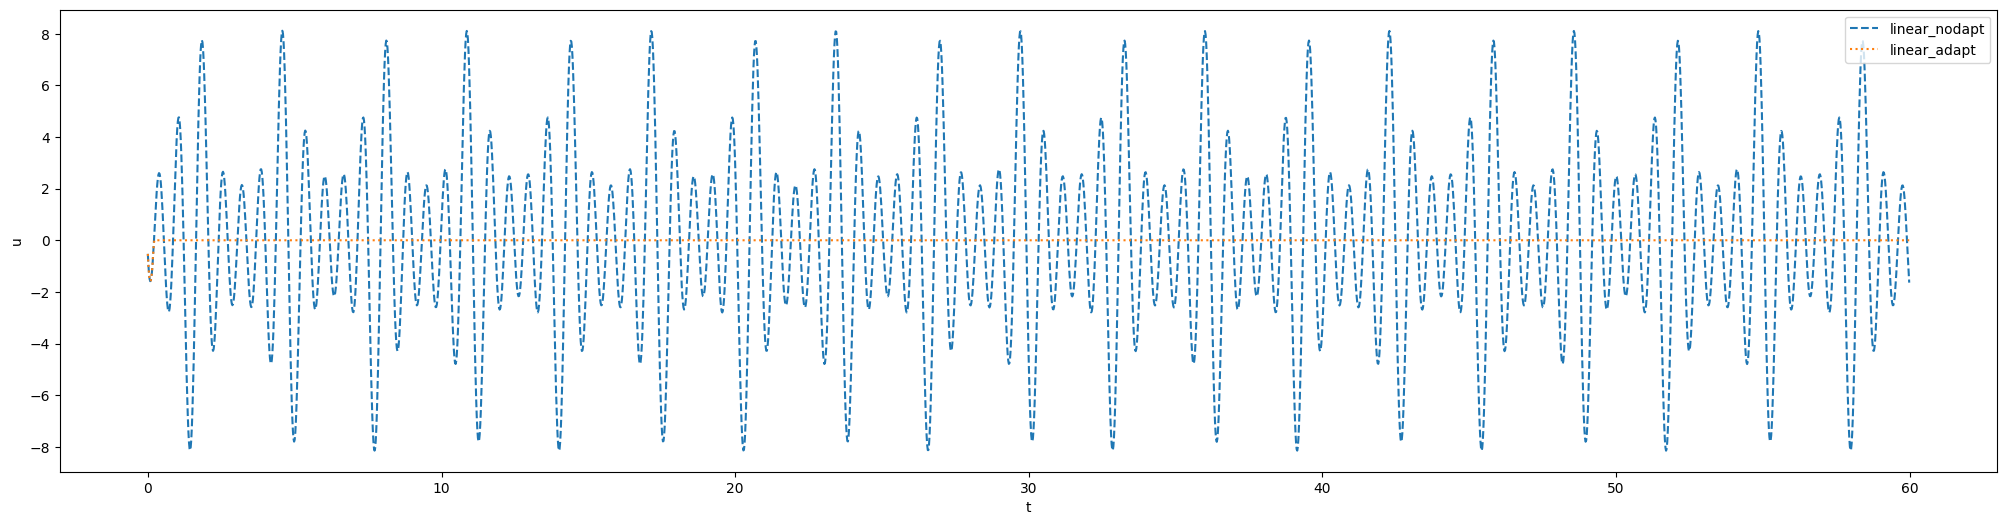

In [58]:

# plot dataset
plt.figure(figsize=(25, 6))
if linear:
    plt.plot(t_eval, u_lin_noadapt,"--", label = 'linear_nodapt')
    plt.plot(t_eval, u_ctrl_lin,":", label = 'linear_adapt')
if bilinear or BMPC:
    plt.plot(t_eval, u_bilin_noadapt, label = 'bilinear_noadapt')
    plt.plot(t_eval, u_ctrl_bilin, label = 'bilinear_adapt')
plt.legend()
plt.xlabel('t')
plt.ylabel('u')
plt.savefig(file_img+'u_changed_dyn.pdf')
plt.show()

In [59]:
from tabulate import  tabulate
import pandas as pd

In [60]:
if linear:
    Data = [["adapt_time", time_linear_adapt],
            ["noadapt_time", time_linear_noadapt],
            ["rmse_error_adapt", error_adapt_lin_norm],
            ['rmse_error_noadapt', error_noadapt_lin_norm]]

if bilinear or BMPC:
    Data = [["adapt_time", time_bilinear_adapt],
            ["noadapt_time", time_bilinear_noadapt],
            ["rmse_error_adapt", error_adapt_bilin_norm],
            ['rmse_error_noadapt', error_noadapt_bilin_norm]]

NameError: name 'time_linear_adapt' is not defined

In [61]:
print(tabulate(Data))

NameError: name 'Data' is not defined

In [ ]:
np.savetxt(file_img+"control_performance.csv", Data, delimiter=',', fmt = '%s')

In [ ]:
percent_improvement = 100*(error_noadapt_lin_norm - error_adapt_lin_norm)/error_noadapt_lin_norm

In [ ]:
percent_improvement